In [27]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from random import random
import seaborn as sns
import warnings

## Setup Functions for Reading csv file

In [2]:
warnings.filterwarnings('ignore')

def dataSetClassesFrequenciesBarPlot(target):
    freqs = target.value_counts() / len(target)

    std_errors = np.sqrt(freqs*(1-freqs)/len(target))
    expected_frequency = 1/len(np.unique(target))
    freqs.plot(kind='bar',yerr=std_errors*1.96)
    plt.axhline(expected_frequency,color='red',linestyle='--')


def get_samples(X):

    attributeNames = []
    
    for elem in X.columns:
        attributeNames.append(elem)

    examples = []

    for row in X.itertuples():
        *attributes, label = row[1:]

        example = dict(zip(attributeNames, attributes))
        example["CLASS"] = label
        examples.append(example)

    return examples

def prepareDataSet(dataSetName):

    dataset_file = dataSetName.lower()

    f_in = open(dataset_file, 'r')
    csv_reader = csv.reader(f_in, delimiter=",")

    row = next(csv_reader)

    attributeNames = row[:-1]

    examples = []
    classes = set()

    for row in csv_reader:
        *attributes, label = row

        classes.add(label)

        example = dict(zip(attributeNames, attributes))
        example["CLASS"] = label
        examples.append(example)

    f_in.close()
    return classes, attributeNames, examples

def convert_to_float(value):
    if isinstance(value, str):
        return float(value.replace(',', ''))
    else:
        return float(value)

## Data Analysis

In [3]:
data = pd.read_csv("date_tema_1_iaut_2024.csv")

classes, attributes, examples = prepareDataSet("date_tema_1_iaut_2024.csv")

classes = sorted(list(classes))

categorical_attributes = [("Diagnostic", 18), 
                        ("Gender", 17), 
                        ("Technology_time_use", 16),
                        ("Calorie_monitoring", 15), 
                        ("Smoker", 14), 
                        ("Snacks", 13),
                        ("Alcohol", 12),
                        ("High_calorie_diet", 11),
                        ("Diagnostic_in_family_history", 10),
                        ("Transportation", 9)]

attrs = attributes.copy()

for elem in categorical_attributes:
    if elem[0] in ["Gender", "Calorie_monitoring", "Smoker", "Snacks",
                    "Alcohol", "High_calorie_diet", "Diagnostic_in_family_history",
                    "Transportation"]:
        attrs.pop(attrs.index(elem[0]))

numerical_attributes = attrs

num_div = 5
ml_dic_div = {}

for elem in numerical_attributes:
    data[elem] = data[elem].apply(convert_to_float)

X = data.loc[:, data.columns[:-1]]
y = data.loc[:, ["Diagnostic"]]

train_count = []
test_count = []

classes_values = {}
for elem in range(len(classes)):
    classes_values[classes[elem]] = {}
    classes_values[classes[elem]]["train"] = []
    classes_values[classes[elem]]["test"] = []

for step in range(10, 100, 10):
    _, _, T_train, T_test = train_test_split(X, y, random_state=10, train_size = step / 100)
    train_count.append(T_train.value_counts())
    test_count.append(T_test.value_counts())

    for elem in range(len(classes)):
        classes_values[classes[elem]]["train"].append(train_count[-1][classes[elem]])
        classes_values[classes[elem]]["test"].append(test_count[-1][classes[elem]])

data["Diagnostic"] = LabelEncoder().fit_transform(data["Diagnostic"])

rand_test_num = int(random() * 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size = .8)

ml_dic_div[rand_test_num] = {}
ml_dic_div[rand_test_num]["T"] = {}
ml_dic_div[rand_test_num]["X"] = {}
ml_dic_div[rand_test_num]["X"]["train"] = pd.DataFrame(X_train).loc[:, attributes]
ml_dic_div[rand_test_num]["T"]["train"] = y_train
ml_dic_div[rand_test_num]["X"]["test"] = pd.DataFrame(X_test).loc[:, attributes]
ml_dic_div[rand_test_num]["T"]["test"] = y_test

print("Classes are " + str(["D" + str(x) for x in range(len(classes))]) + "\n")

for i in range(len(classes)):

    print("*"*50)

    print("Number of '{}' values in Training Set : ".format(classes[i]) \
            + str(round(sum(classes_values[classes[i]]["train"]) / len(classes_values[classes[i]]["train"]))))

    print("Number of '{}' values in Testing Set : ".format(classes[i]) \
            + str(round(sum(classes_values[classes[i]]["test"]) / len(classes_values[classes[i]]["test"]))))
    print("*"*50 + "\n")

Classes are ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']

**************************************************
Number of 'D0' values in Training Set : 132
Number of 'D0' values in Testing Set : 114
**************************************************

**************************************************
Number of 'D1' values in Training Set : 126
Number of 'D1' values in Testing Set : 136
**************************************************

**************************************************
Number of 'D2' values in Training Set : 124
Number of 'D2' values in Testing Set : 134
**************************************************

**************************************************
Number of 'D3' values in Training Set : 132
Number of 'D3' values in Testing Set : 137
**************************************************

**************************************************
Number of 'D4' values in Training Set : 164
Number of 'D4' values in Testing Set : 156
**********************************************

Frequencies for Training Set


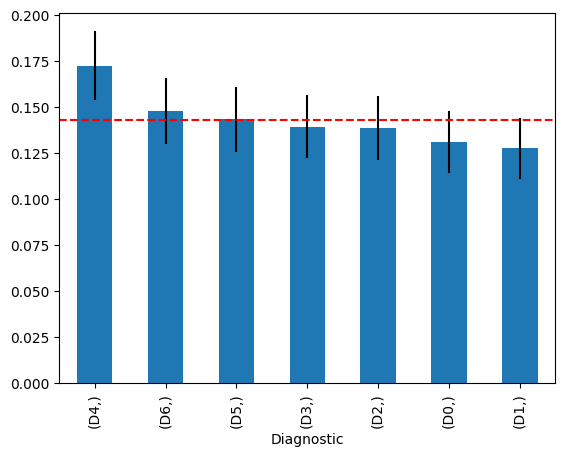

In [45]:
print("Frequencies for Training Set")
dataSetClassesFrequenciesBarPlot(ml_dic_div[rand_test_num]["T"]["train"])

Frequencies for Testing Set


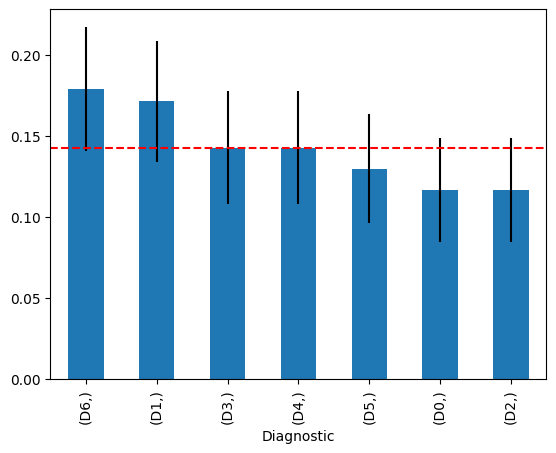

In [46]:
print("Frequencies for Testing Set")
dataSetClassesFrequenciesBarPlot(ml_dic_div[rand_test_num]["T"]["test"])

In [93]:
def count(list, l, r):
    list.sort()

    left_idx = bisect.bisect_left(list, l)

    right_idx = bisect.bisect_right(list, r)

    count = right_idx - left_idx

    return count

num_samples_dict_train = {}
num_samples_dict_test = {}

print("Series info for train set:\n")

for elem in numerical_attributes:
    num_samples_dict_train[elem] = []
    aux_list = ml_dic_div[rand_test_num]["X"]["train"][elem]

    print("*"*50)

    for i_quant in range(0, 100, 10):
        lower_bound = np.percentile(list(aux_list), i_quant)
        upper_bound = np.percentile(list(aux_list), i_quant + 10)
        num_samples_dict_train[elem].append(count(list(aux_list), lower_bound, upper_bound))

    print(aux_list.describe(include="all"))
    
    print("*"*50 + "\n")

print("Series info for test set:\n")

for elem in numerical_attributes:
    num_samples_dict_test[elem] = []
    aux_list = ml_dic_div[rand_test_num]["X"]["test"][elem]

    print("*"*50)

    for i_quant in range(0, 100, 10):
        lower_bound = np.percentile(list(aux_list), i_quant)
        upper_bound = np.percentile(list(aux_list), i_quant + 10)
        num_samples_dict_test[elem].append(count(list(aux_list), lower_bound, upper_bound))

    print(aux_list.describe(include="all"))
    
    print("*"*50 + "\n")

Series info for train set:

**************************************************
count    1.536000e+03
mean     8.069497e+05
std      1.131293e+06
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      2.050785e+06
max      2.998441e+06
Name: Regular_fiber_diet, dtype: float64
**************************************************

**************************************************
count     1536.000000
mean       354.143880
std       2435.341879
min          3.000000
25%        258.000000
50%        306.000000
75%        354.250000
max      95658.000000
Name: Sedentary_hours_daily, dtype: float64
**************************************************

**************************************************
count    1.536000e+03
mean     1.479137e+07
std      1.305028e+07
min      1.500000e+01
25%      2.600000e+01
50%      1.908464e+07
75%      2.421222e+07
max      5.513788e+07
Name: Age, dtype: float64
**************************************************

************************

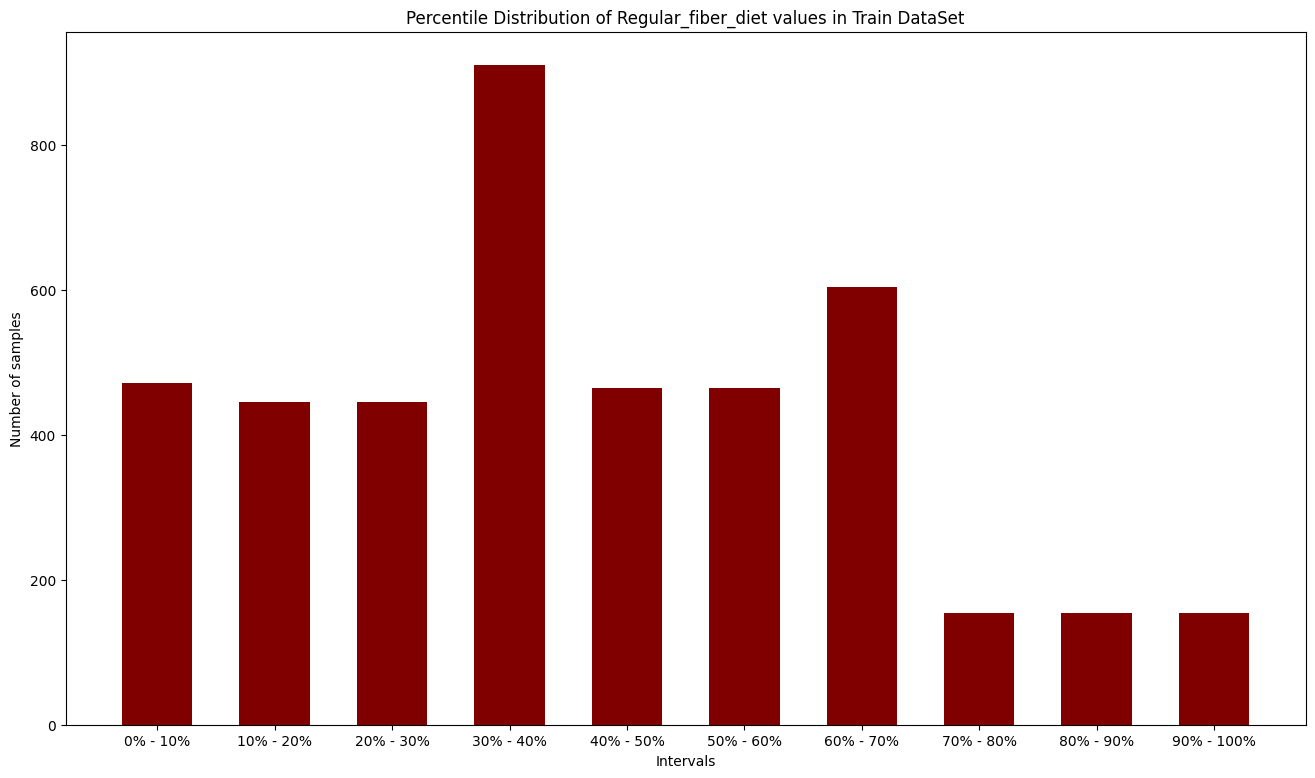

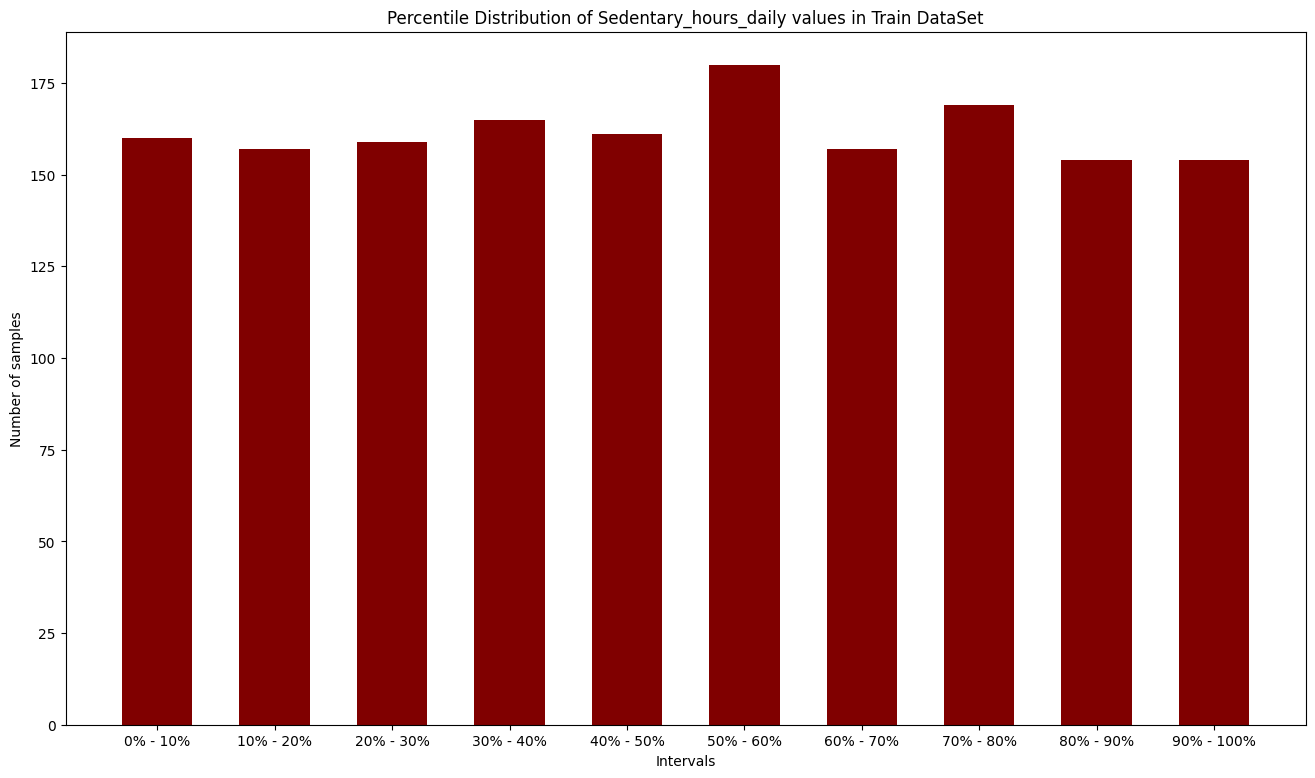

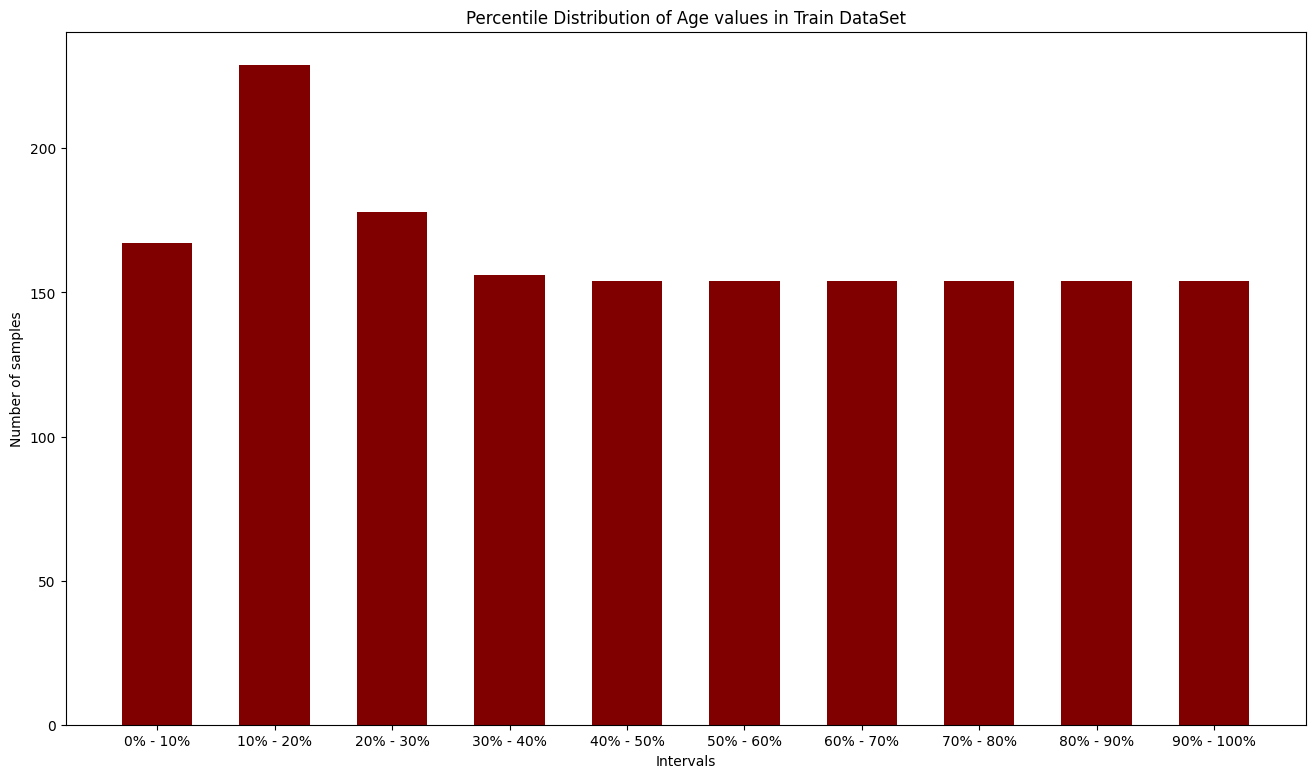

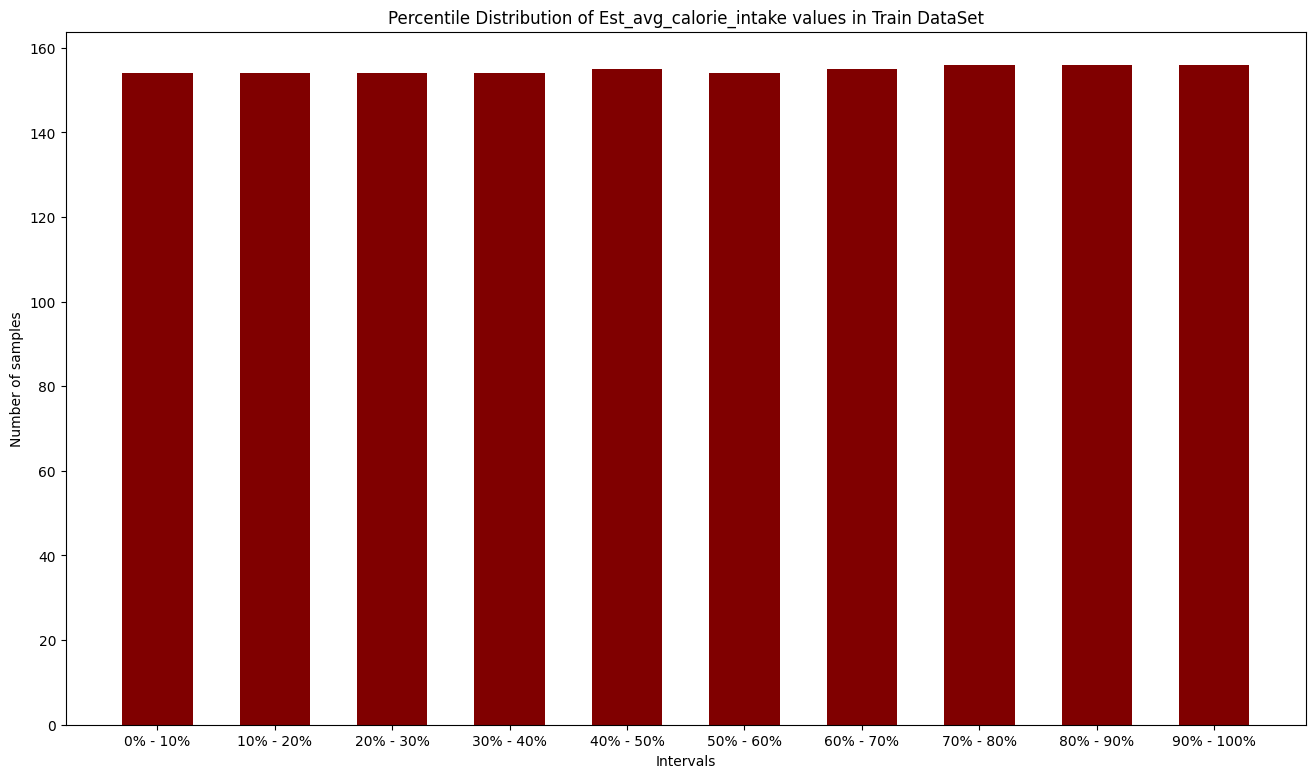

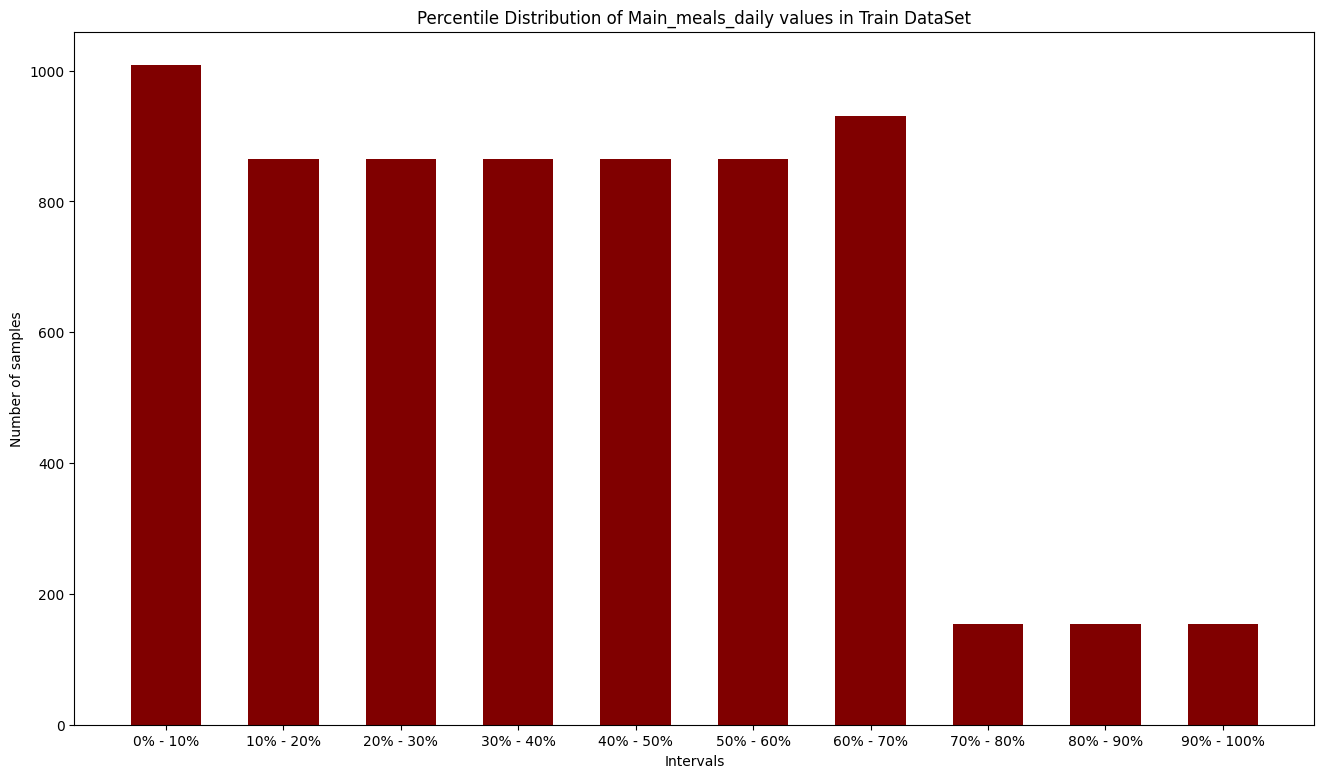

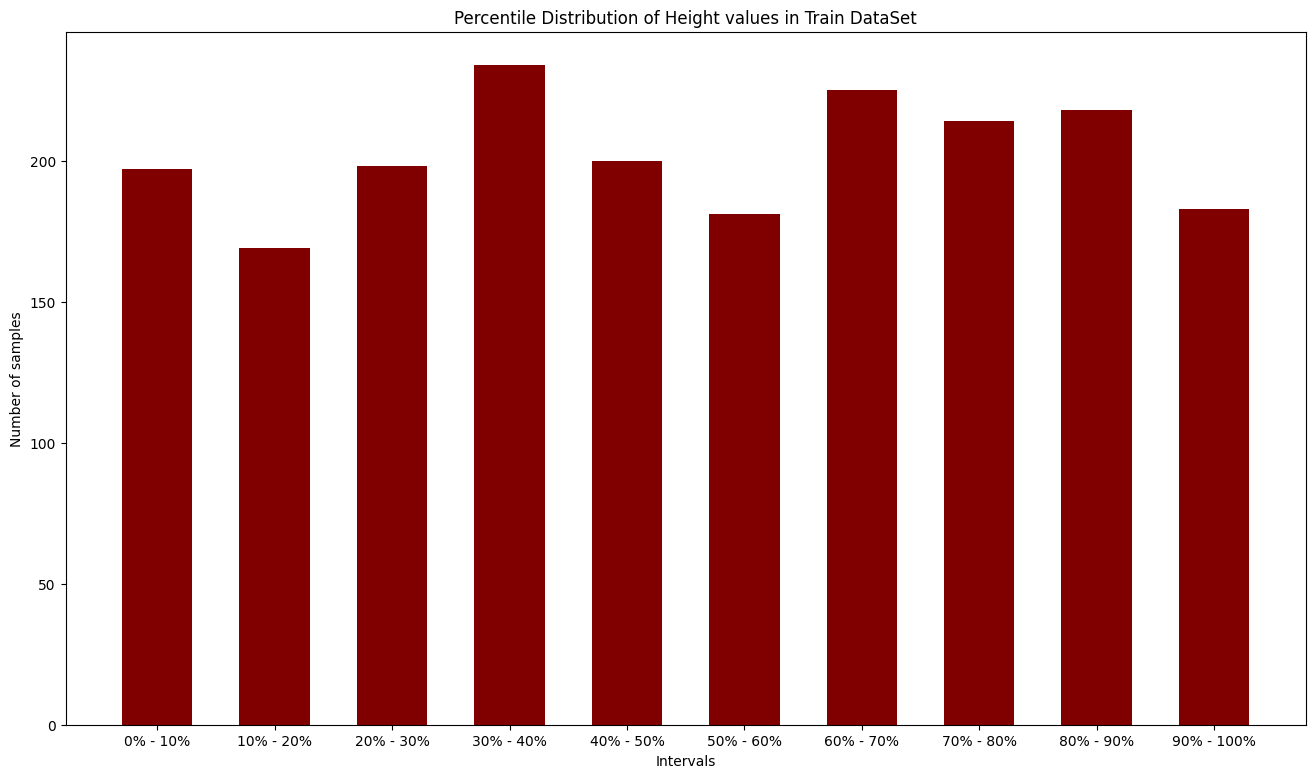

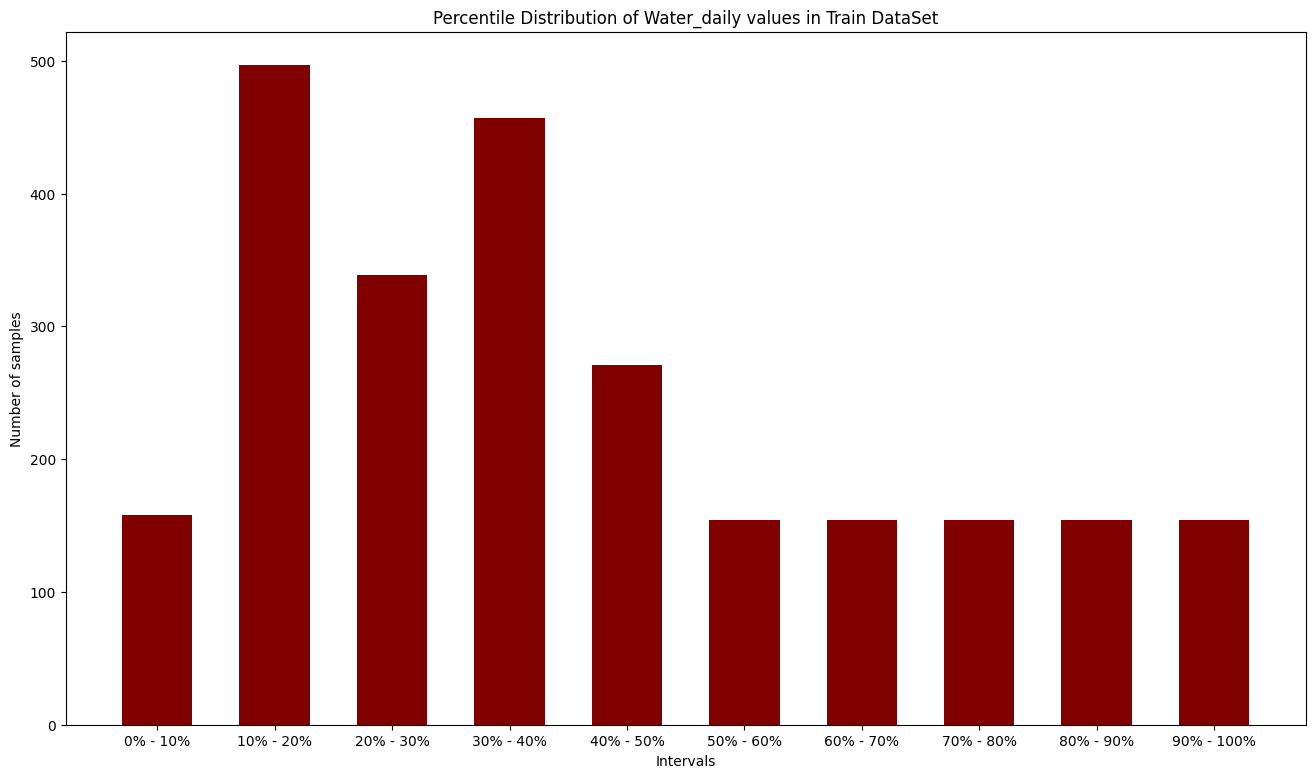

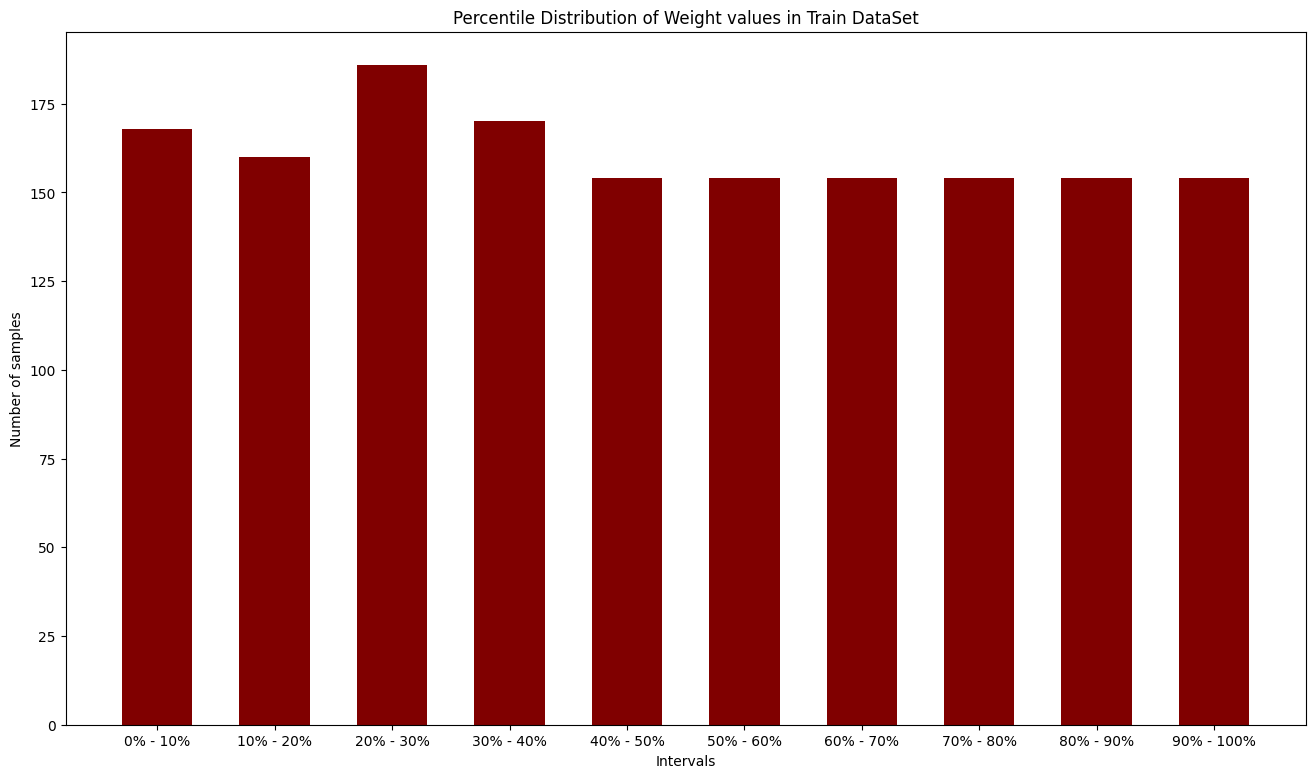

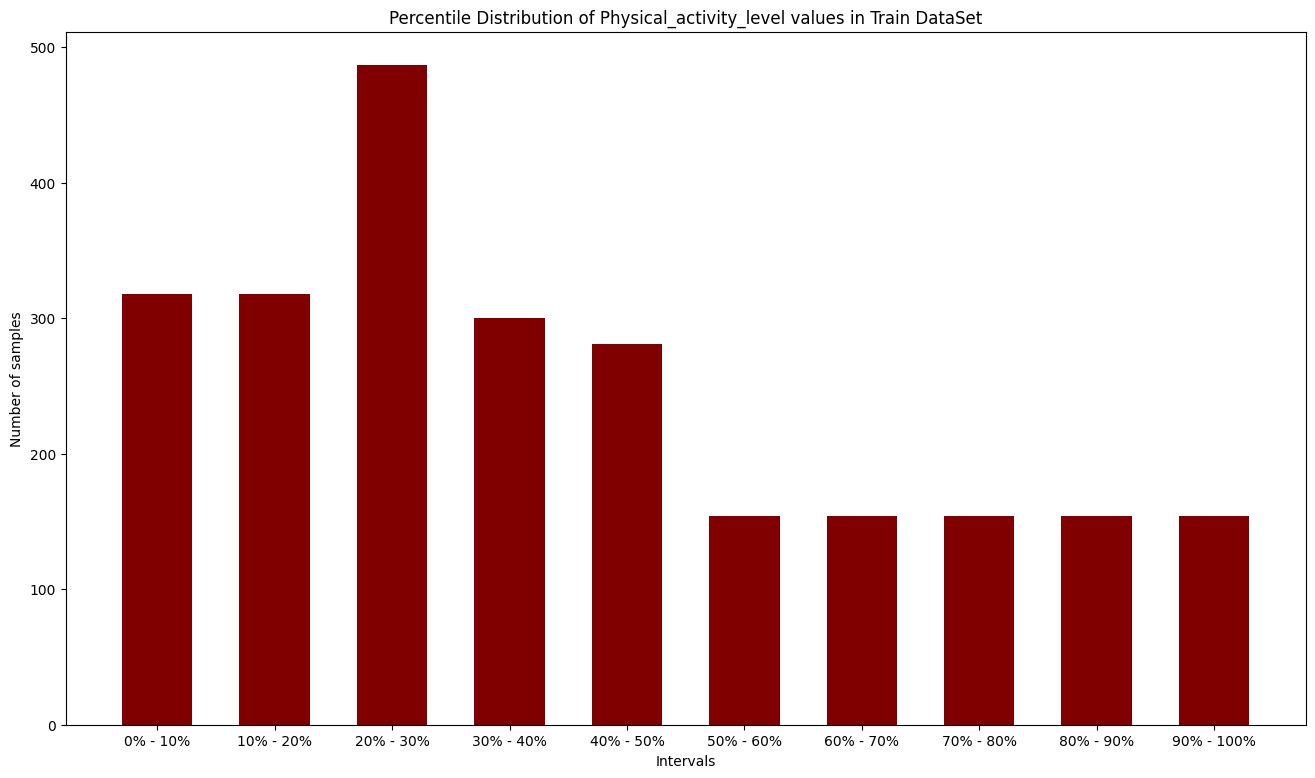

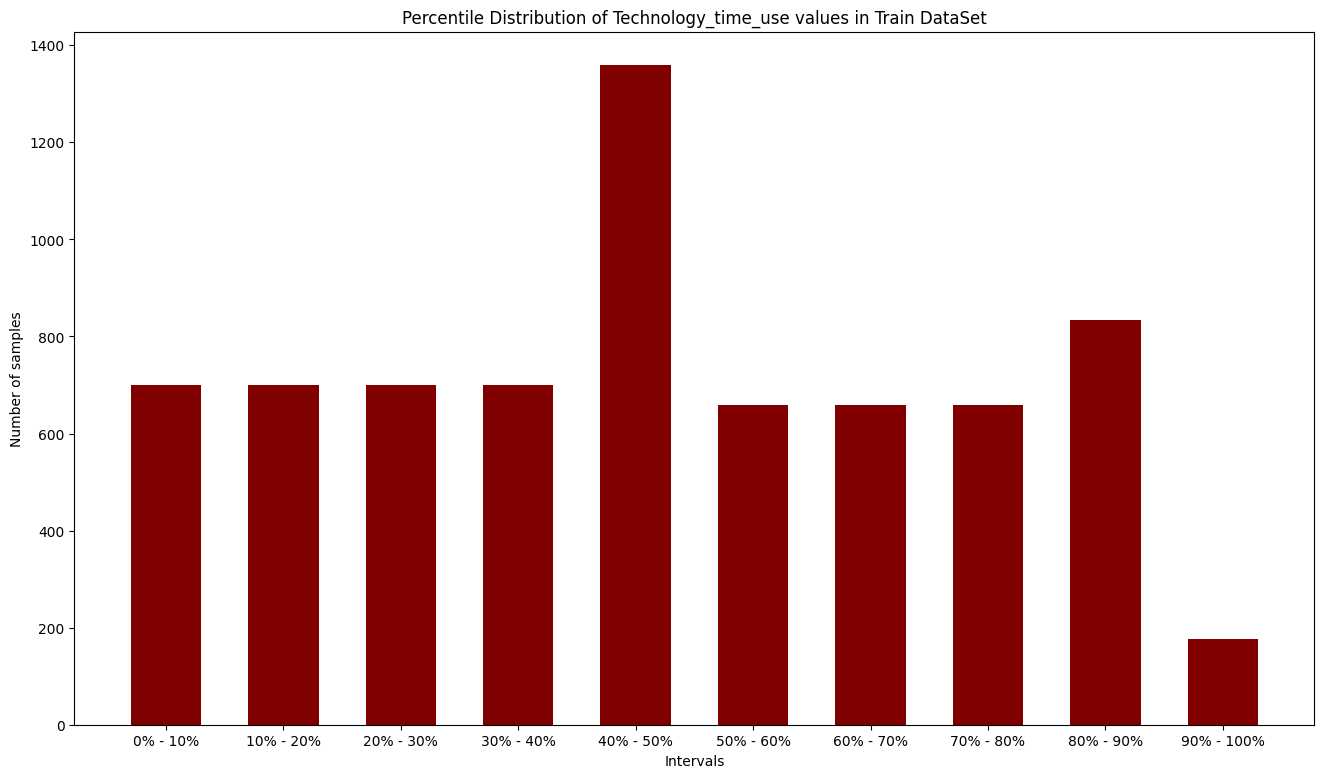

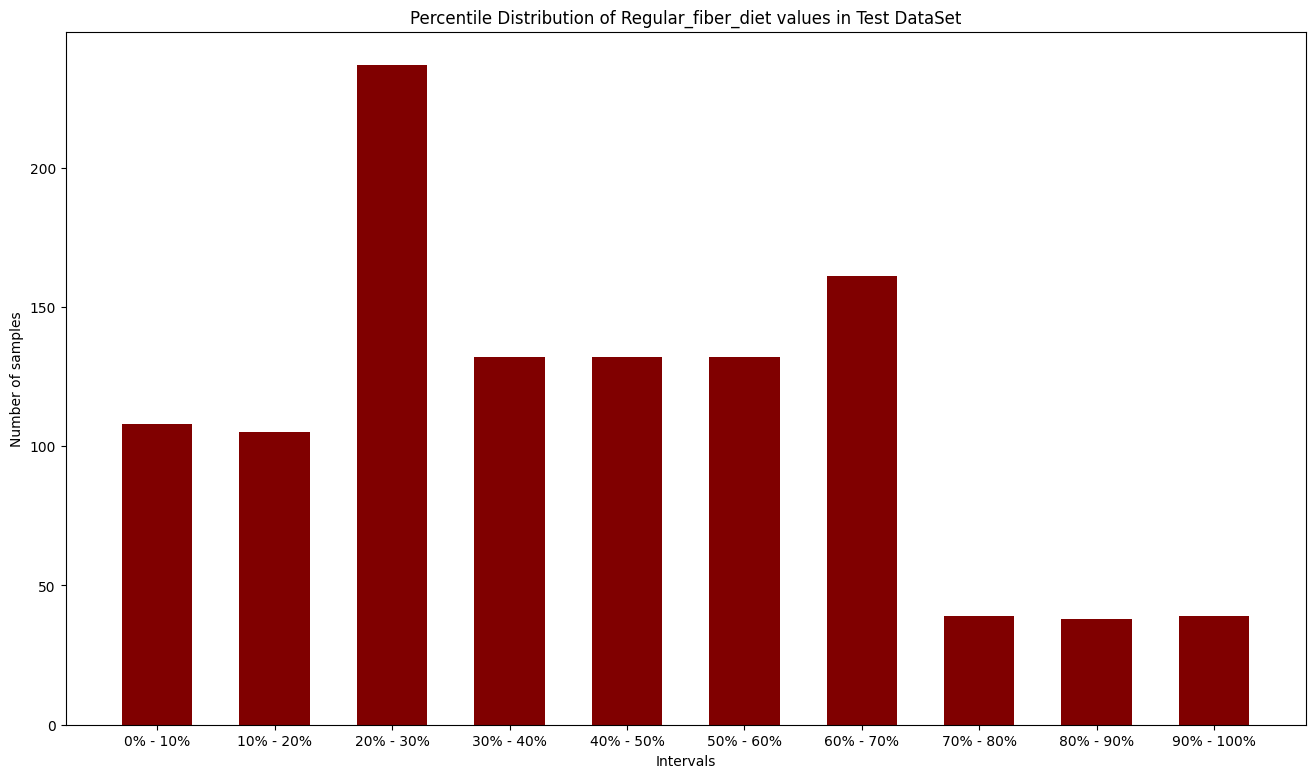

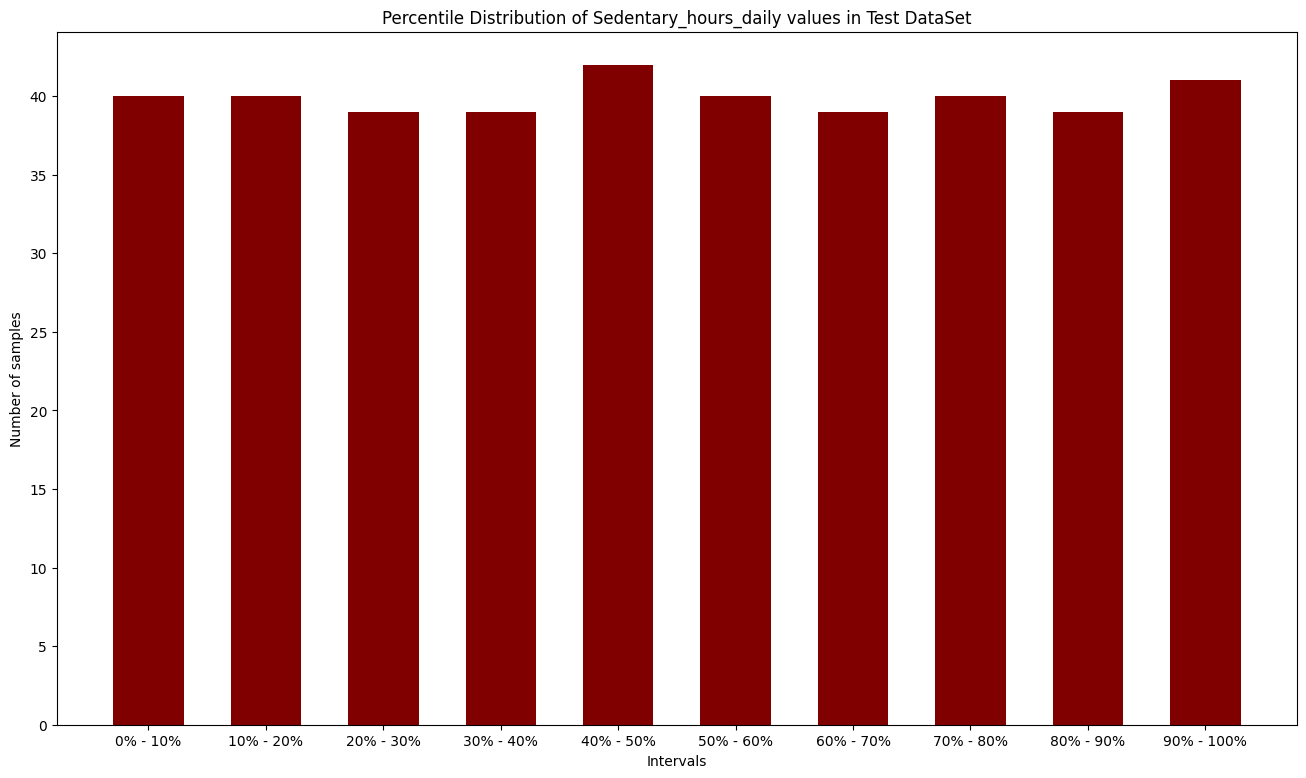

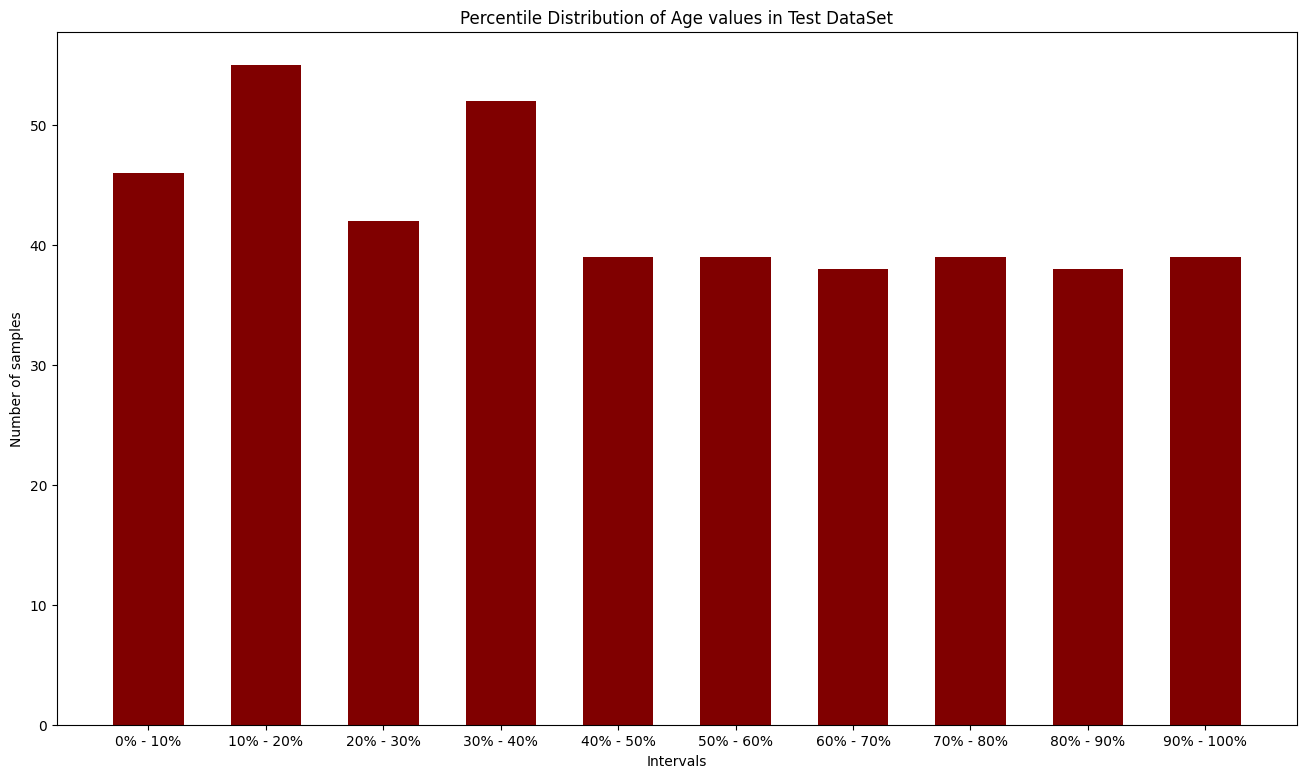

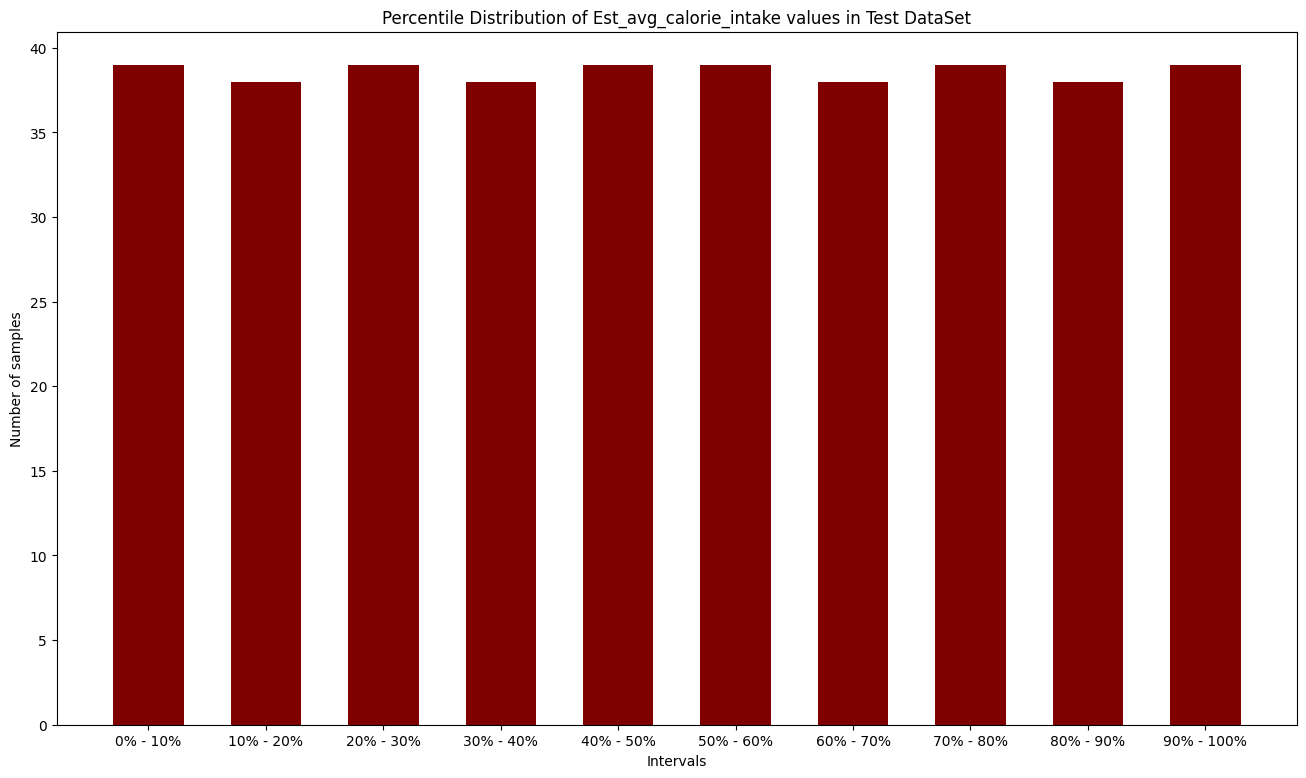

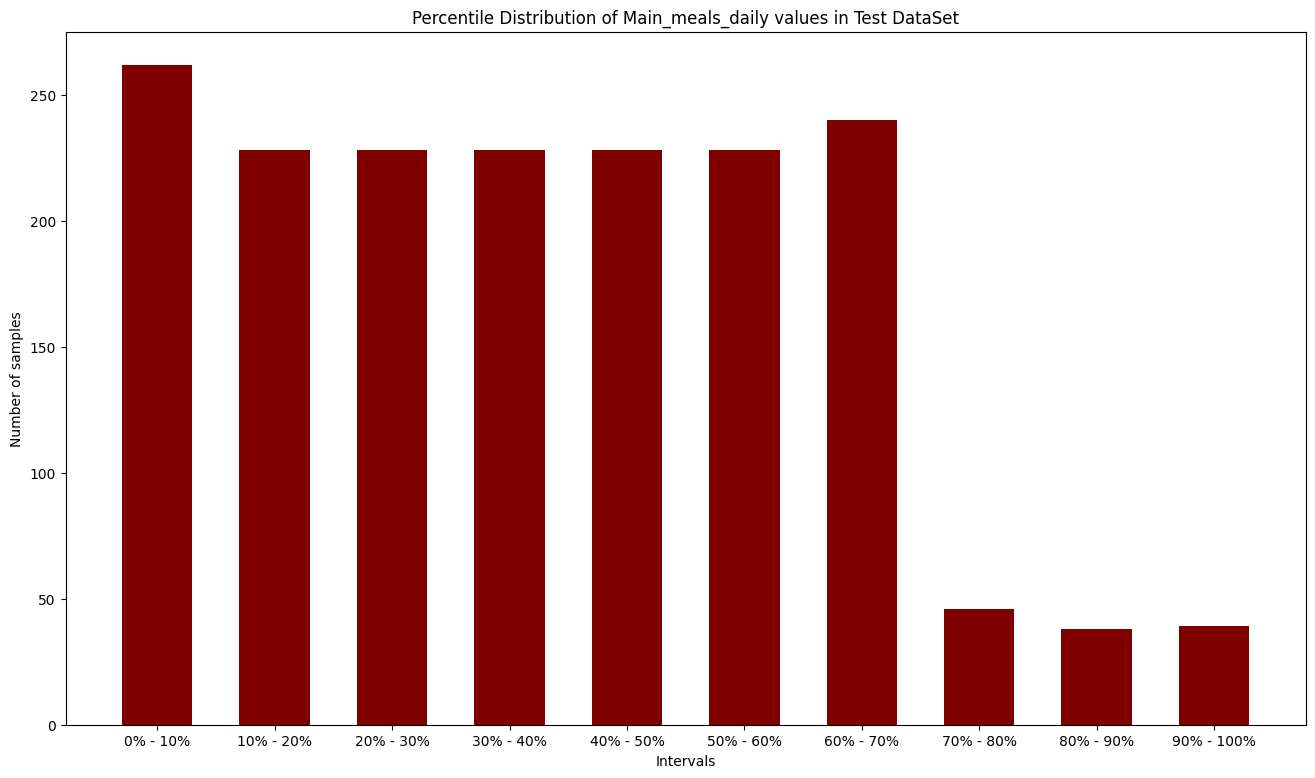

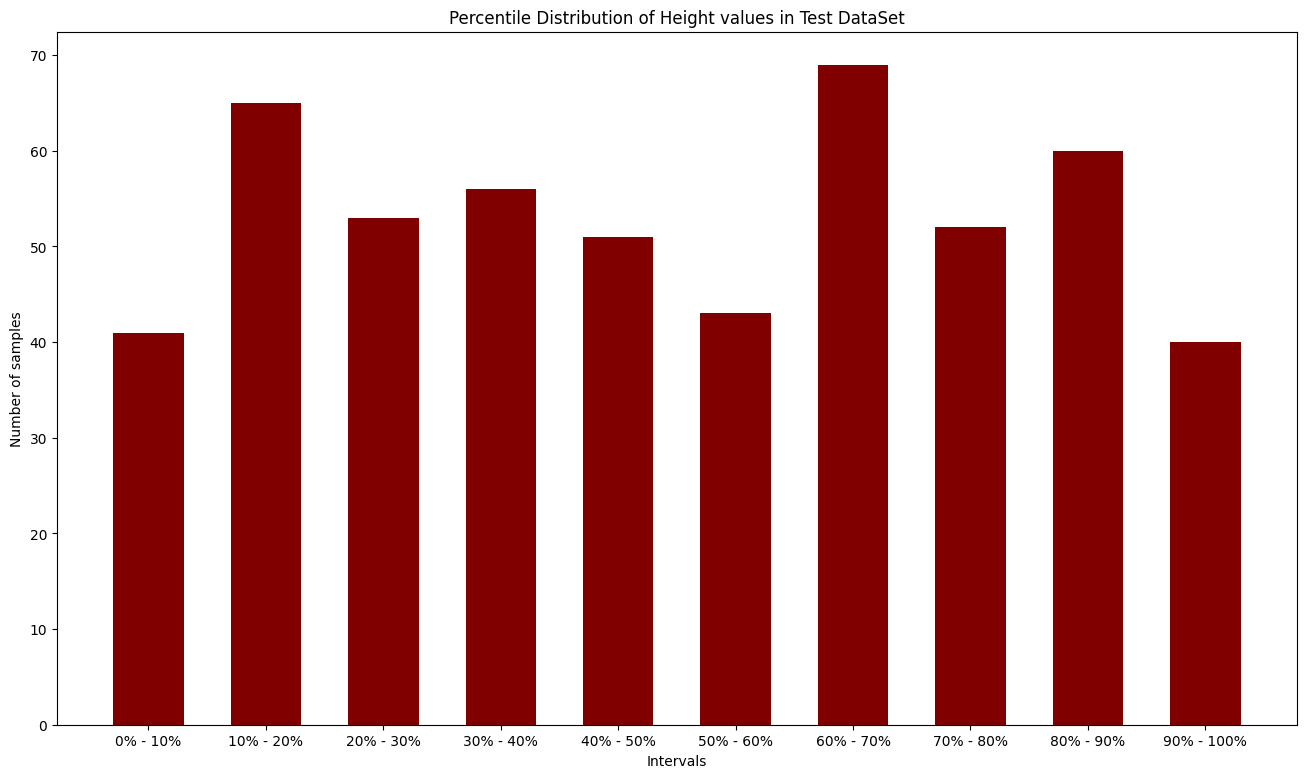

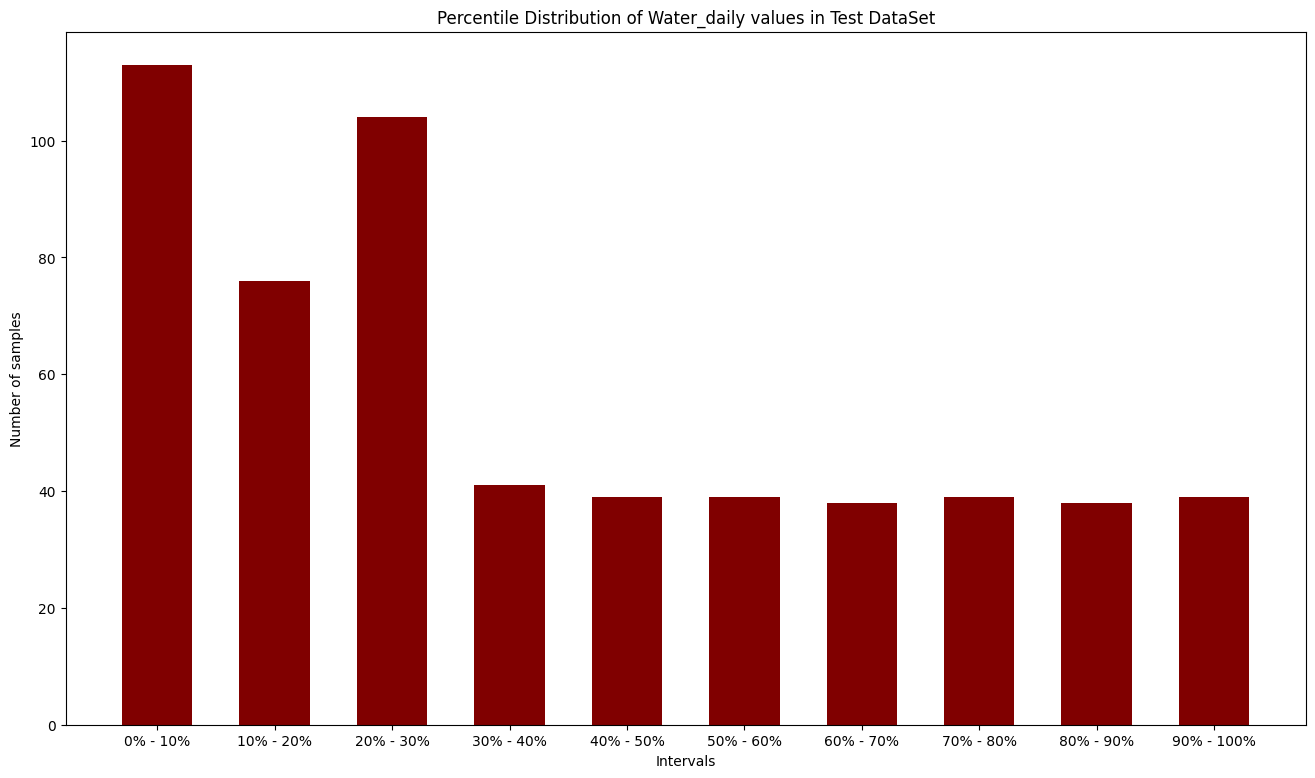

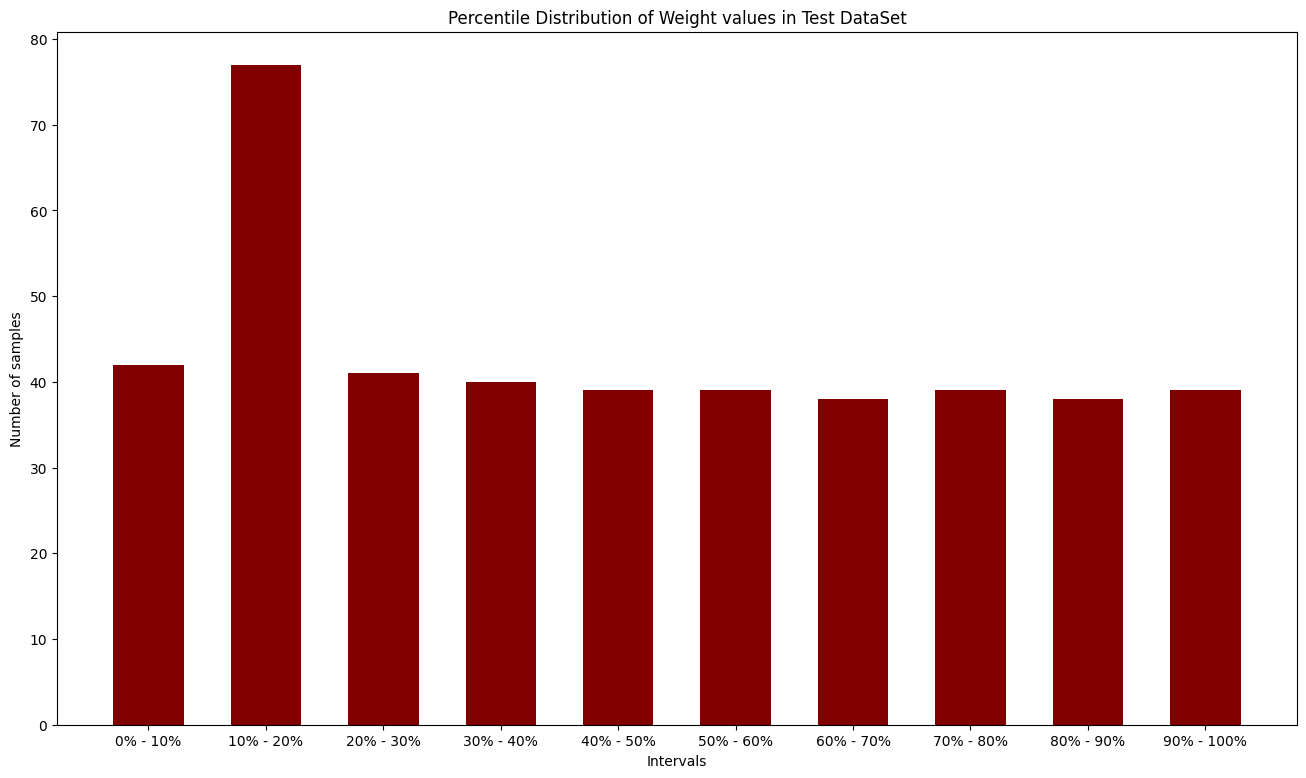

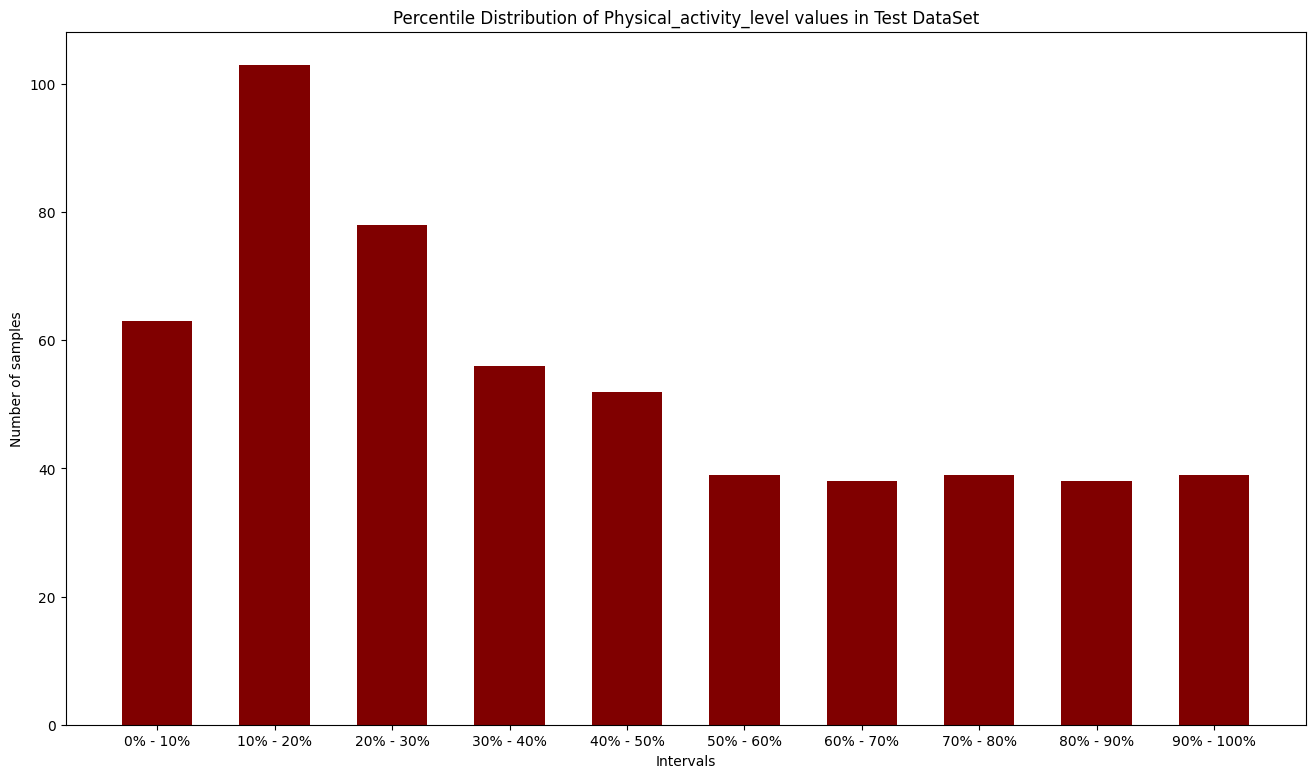

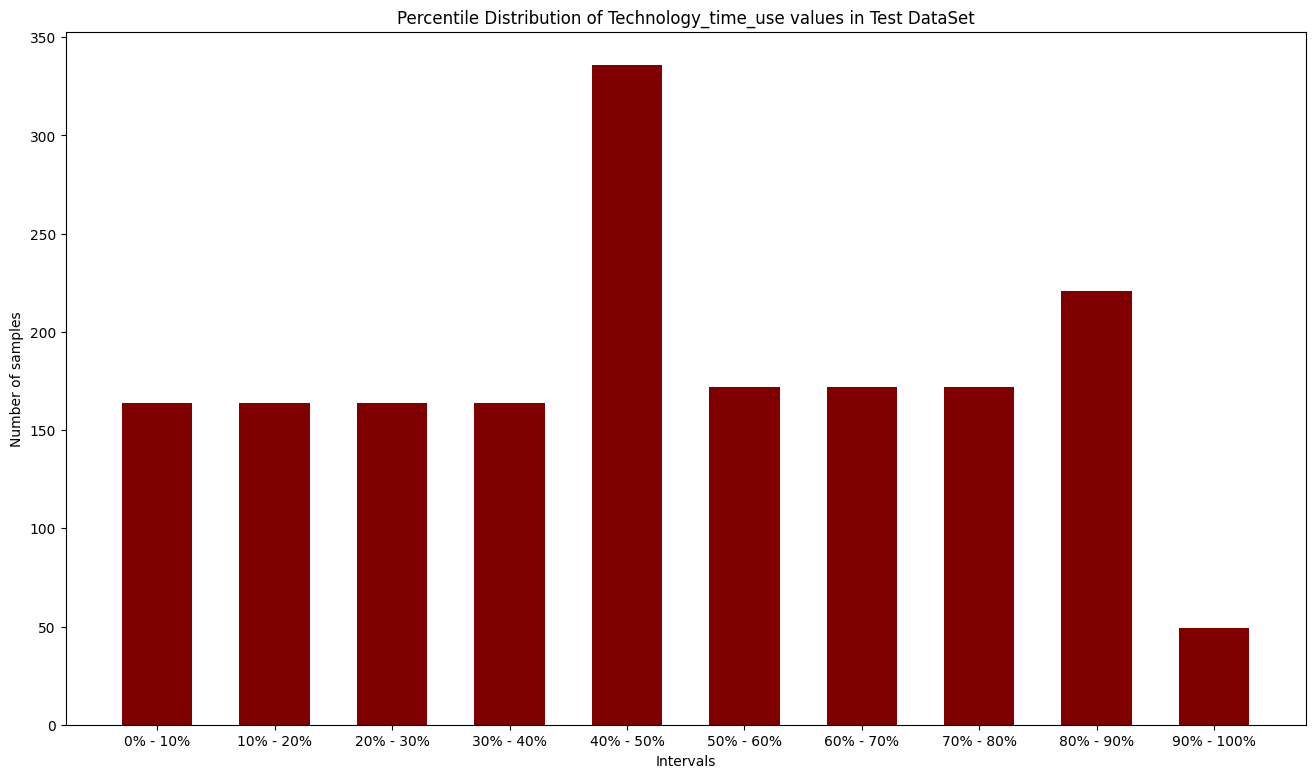

In [48]:
def plot_func(num_samples_dict, attribute, type : str):
    data = {}

    index = 0
    for elem in num_samples_dict:
        curr_key = "{}% - {}%".format(index * 10, (index + 1) * 10)
        data[curr_key] = elem
        index = index + 1

    intervals = list(data.keys())
    values = list(data.values())

    plt.figure(figsize = (16, 9))
    plt.bar(intervals, values, color ='maroon', 
        width = 0.6)
    plt.xlabel("Intervals")
    plt.ylabel("Number of samples")
    plt.title("Percentile Distribution of {} values in {} DataSet".format(attribute, type))
    plt.show()

for elem in numerical_attributes:
    plot_func(num_samples_dict_train[elem], elem, "Train")

for elem in numerical_attributes:
    plot_func(num_samples_dict_test[elem], elem, "Test")

<Axes: xlabel='Gender'>

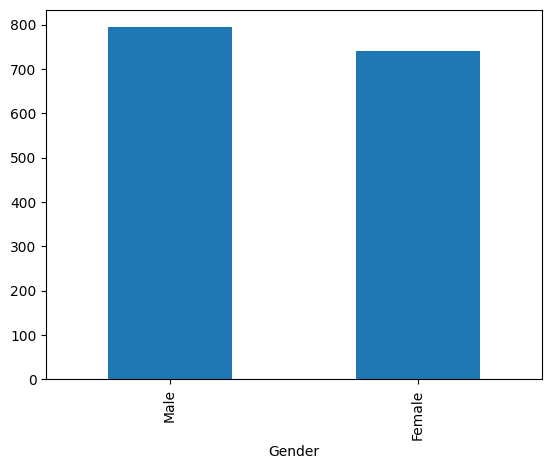

In [49]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[1][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Gender'>

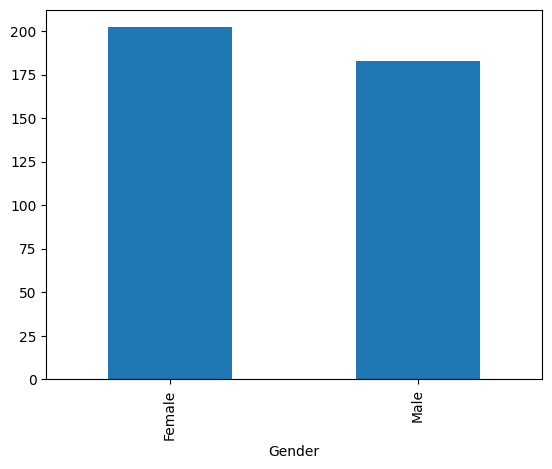

In [50]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[1][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Technology_time_use'>

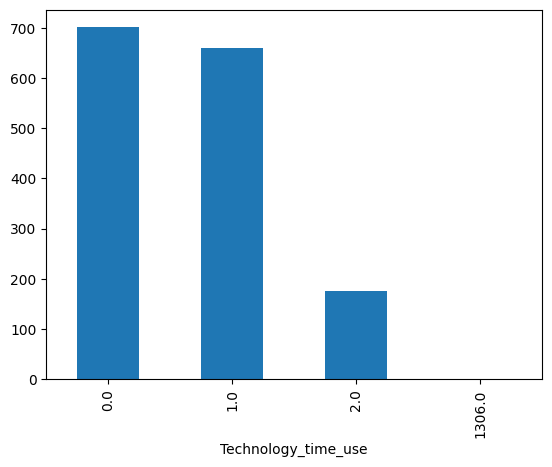

In [51]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[2][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Technology_time_use'>

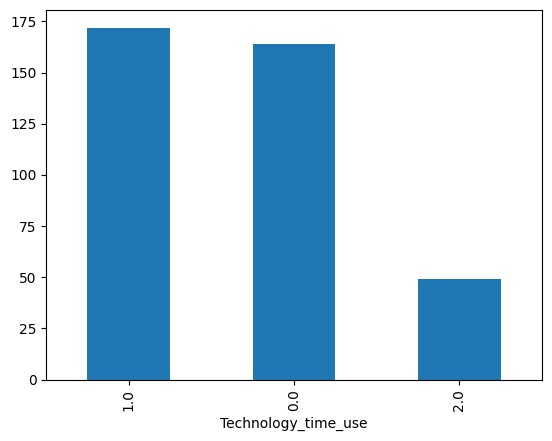

In [52]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[2][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Calorie_monitoring'>

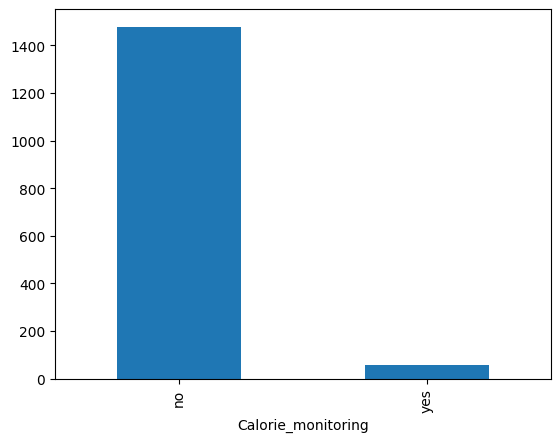

In [53]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[3][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Calorie_monitoring'>

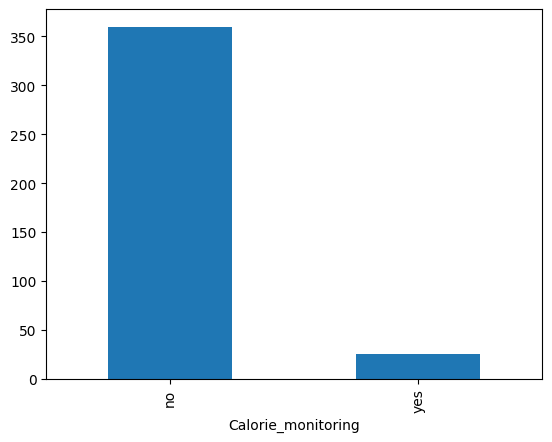

In [54]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[3][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Smoker'>

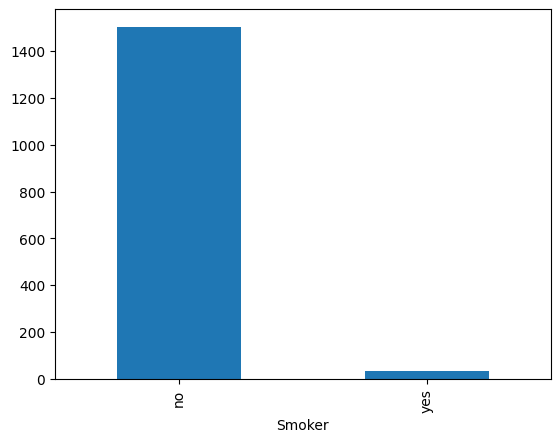

In [55]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[4][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Smoker'>

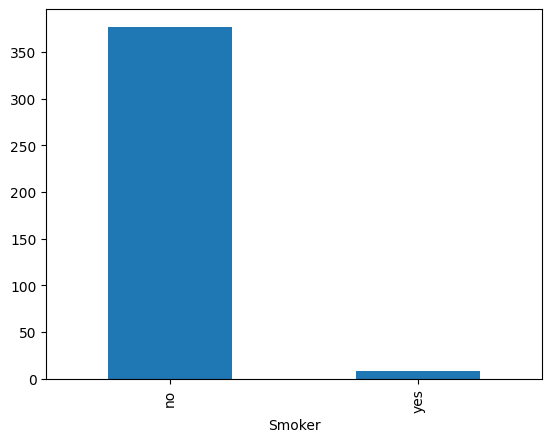

In [56]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[4][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Snacks'>

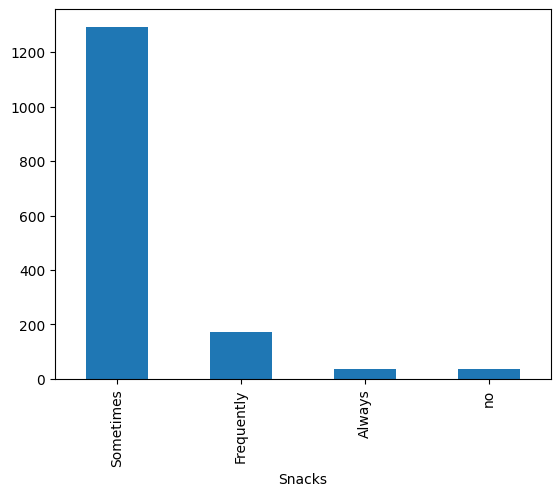

In [57]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[5][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Snacks'>

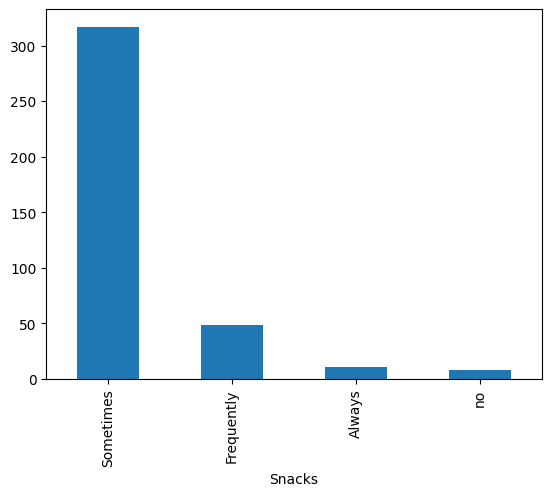

In [58]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[5][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Alcohol'>

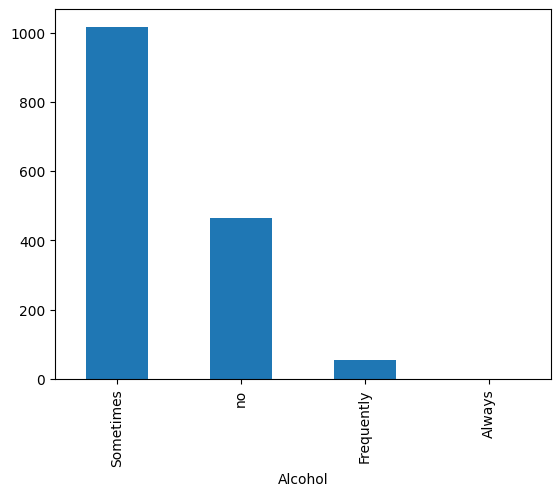

In [59]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[6][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Alcohol'>

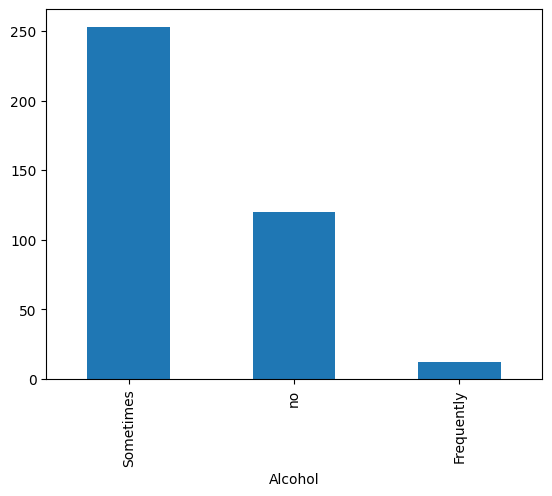

In [60]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[6][0]].value_counts().plot(kind='bar')

<Axes: xlabel='High_calorie_diet'>

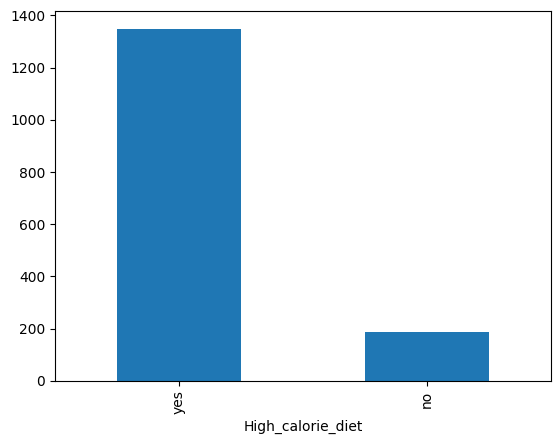

In [61]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[7][0]].value_counts().plot(kind='bar')

<Axes: xlabel='High_calorie_diet'>

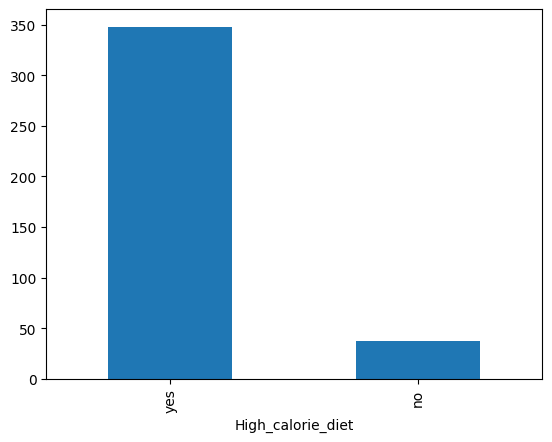

In [62]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[7][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Diagnostic_in_family_history'>

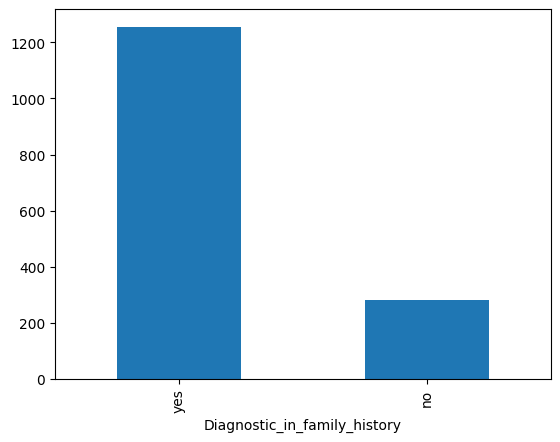

In [63]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[8][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Diagnostic_in_family_history'>

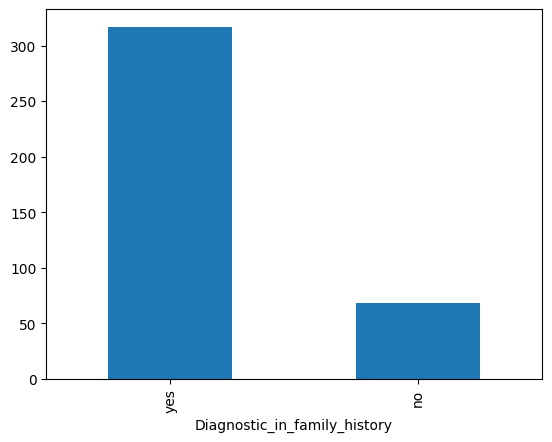

In [64]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[8][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Transportation'>

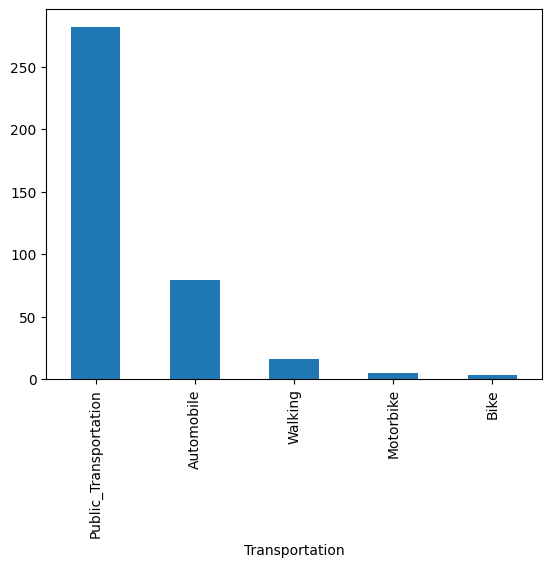

In [65]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[9][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Transportation'>

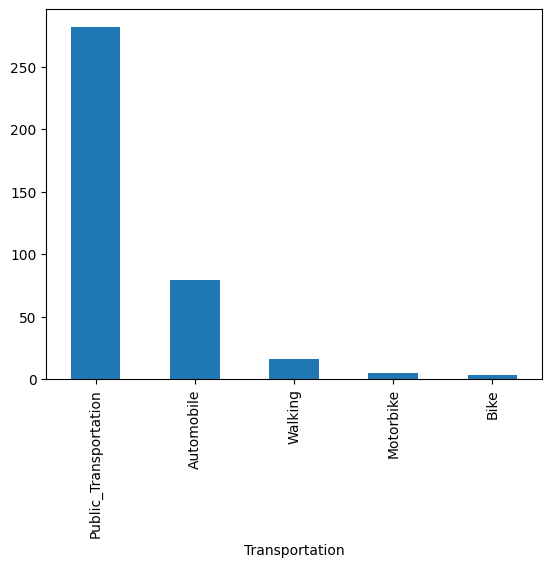

In [66]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[9][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Diagnostic'>

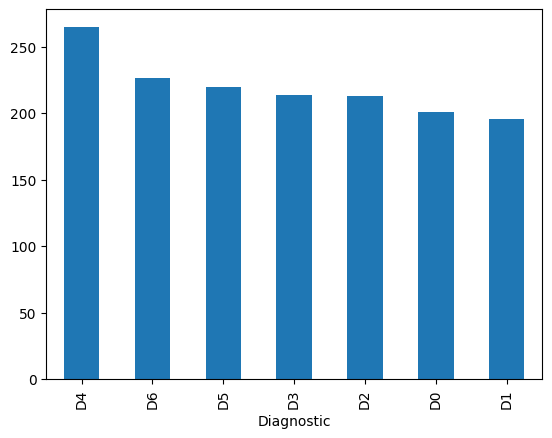

In [67]:
ml_dic_div[rand_test_num]["T"]["train"][categorical_attributes[0][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Diagnostic'>

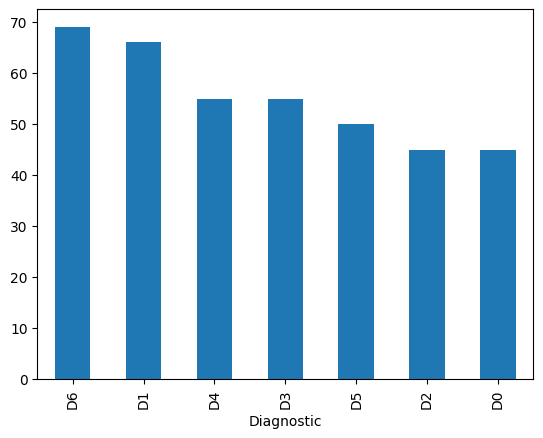

In [68]:
ml_dic_div[rand_test_num]["T"]["test"][categorical_attributes[0][0]].value_counts().plot(kind='bar')

Point-Biserial Correlation value for attribute Regular_fiber_diet : 0.004030509689587913
P-value for attribute Regular_fiber_diet : 0.8598698798496751
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Sedentary_hours_daily : -0.014541003283008135
P-value for attribute Sedentary_hours_daily : 0.5241641960154592
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Age : 0.31648715221609125
P-value for attribute Age : 5.9934317061379605e-46
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Est_avg_calorie_intake : -0.038297539942889605
P-value for attribute Est_avg_calorie_intake : 0.09333263270043171
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Main_meals_daily : -0.12627854616819703
P-v

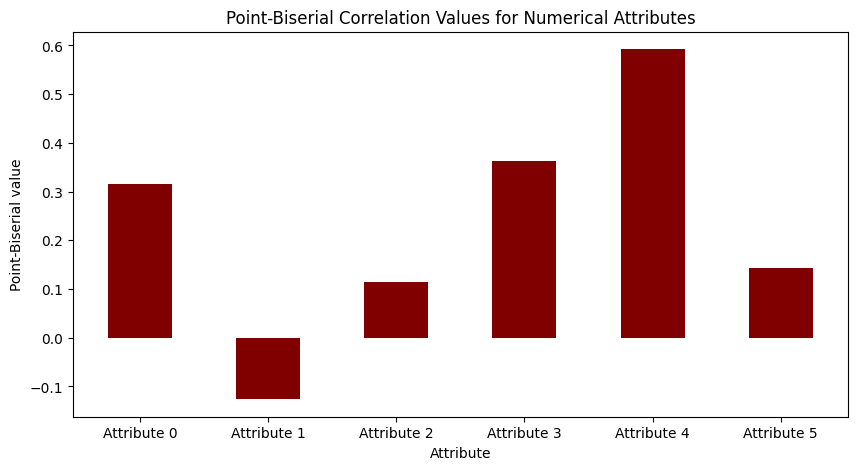

In [4]:
pts_biserial = []

for elem in numerical_attributes:
    p_value = stats.pointbiserialr(data["Diagnostic"], data[elem])[1]
    biserial_val = stats.pointbiserialr(data["Diagnostic"], data[elem])[0]
    if p_value <= 0.05:
        pts_biserial.append((biserial_val, elem))
    print("Point-Biserial Correlation value for attribute {} : {}".format(elem,biserial_val))
    print("P-value for attribute {} : {}".format(elem, p_value))
    print("------------------------------------------------------------------------------")

info_dict = {}
index = 0
for elem in pts_biserial:
    curr_key = "Attribute {}".format(index)
    print(curr_key + " -> " + elem[1])
    info_dict[curr_key] = elem[0]
    index = index + 1

attrs = list(info_dict.keys())
values = list(info_dict.values())

plt.figure(figsize = (10, 5))
plt.bar(attrs, values, color ='maroon', 
        width = 0.5)

plt.xlabel("Attribute")
plt.ylabel("Point-Biserial value")
plt.title("Point-Biserial Correlation Values for Numerical Attributes")
plt.show()

Chi-Squared Statistical value for attribute Gender : 594.5053427289425
P-value for attribute Gender : 7.853306386350789e-118
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Technology_time_use : 172.85410378827623
P-value for attribute Technology_time_use : 8.263301320665811e-23
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Calorie_monitoring : 111.023192122826
P-value for attribute Calorie_monitoring : 3.5420109142245403e-17
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Smoker : 30.310408327994228
P-value for attribute Smoker : 0.006914779971251214
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Snacks : 706.2470089058085
P-value for attribute Snacks : 9.669808647267764e-131
-----------

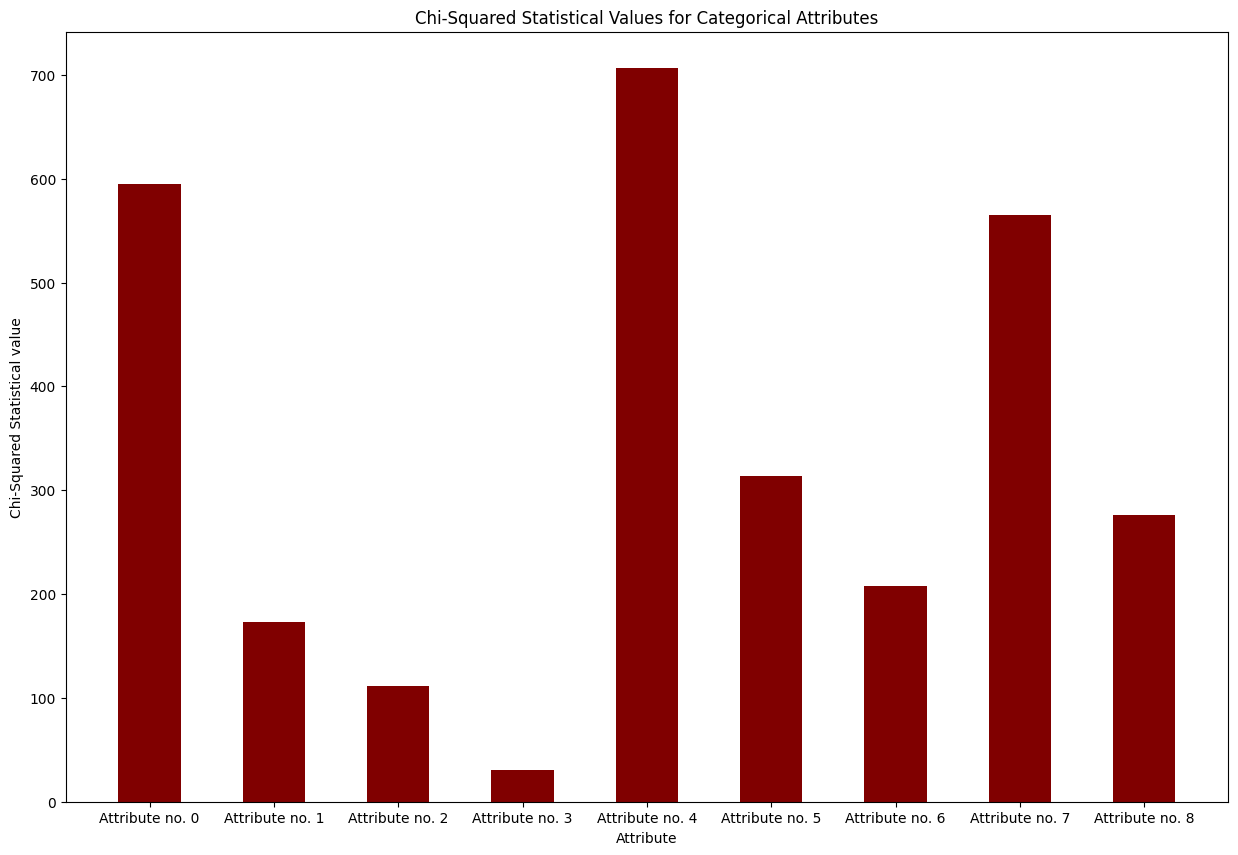

In [5]:
chi2_value = []

for elem in categorical_attributes:
    if elem[0] != "Diagnostic":
        chisqt = pd.crosstab(data[elem[0]], data.Diagnostic, margins=True)
        p_value = chi2_contingency(chisqt)[0:3][1]
        chi2_stat = chi2_contingency(chisqt)[0:3][0]
        if p_value <= 0.05:
            chi2_value.append((chi2_stat, elem[0]))
        print("Chi-Squared Statistical value for attribute {} : {}".format(elem[0],chi2_stat))
        print("P-value for attribute {} : {}".format(elem[0], p_value))
        print("------------------------------------------------------------------------------")

info_dict = {}
index = 0
for elem in chi2_value:
    curr_key = "Attribute no. {}".format(index)
    print(curr_key + " -> " + elem[1])
    info_dict[curr_key] = elem[0]
    index = index + 1

attrs = list(info_dict.keys())
values = list(info_dict.values())

plt.figure(figsize = (15, 10))
plt.bar(attrs, values, color ='maroon', 
        width = 0.5)

plt.xlabel("Attribute")
plt.ylabel("Chi-Squared Statistical value")
plt.title("Chi-Squared Statistical Values for Categorical Attributes")
plt.show()

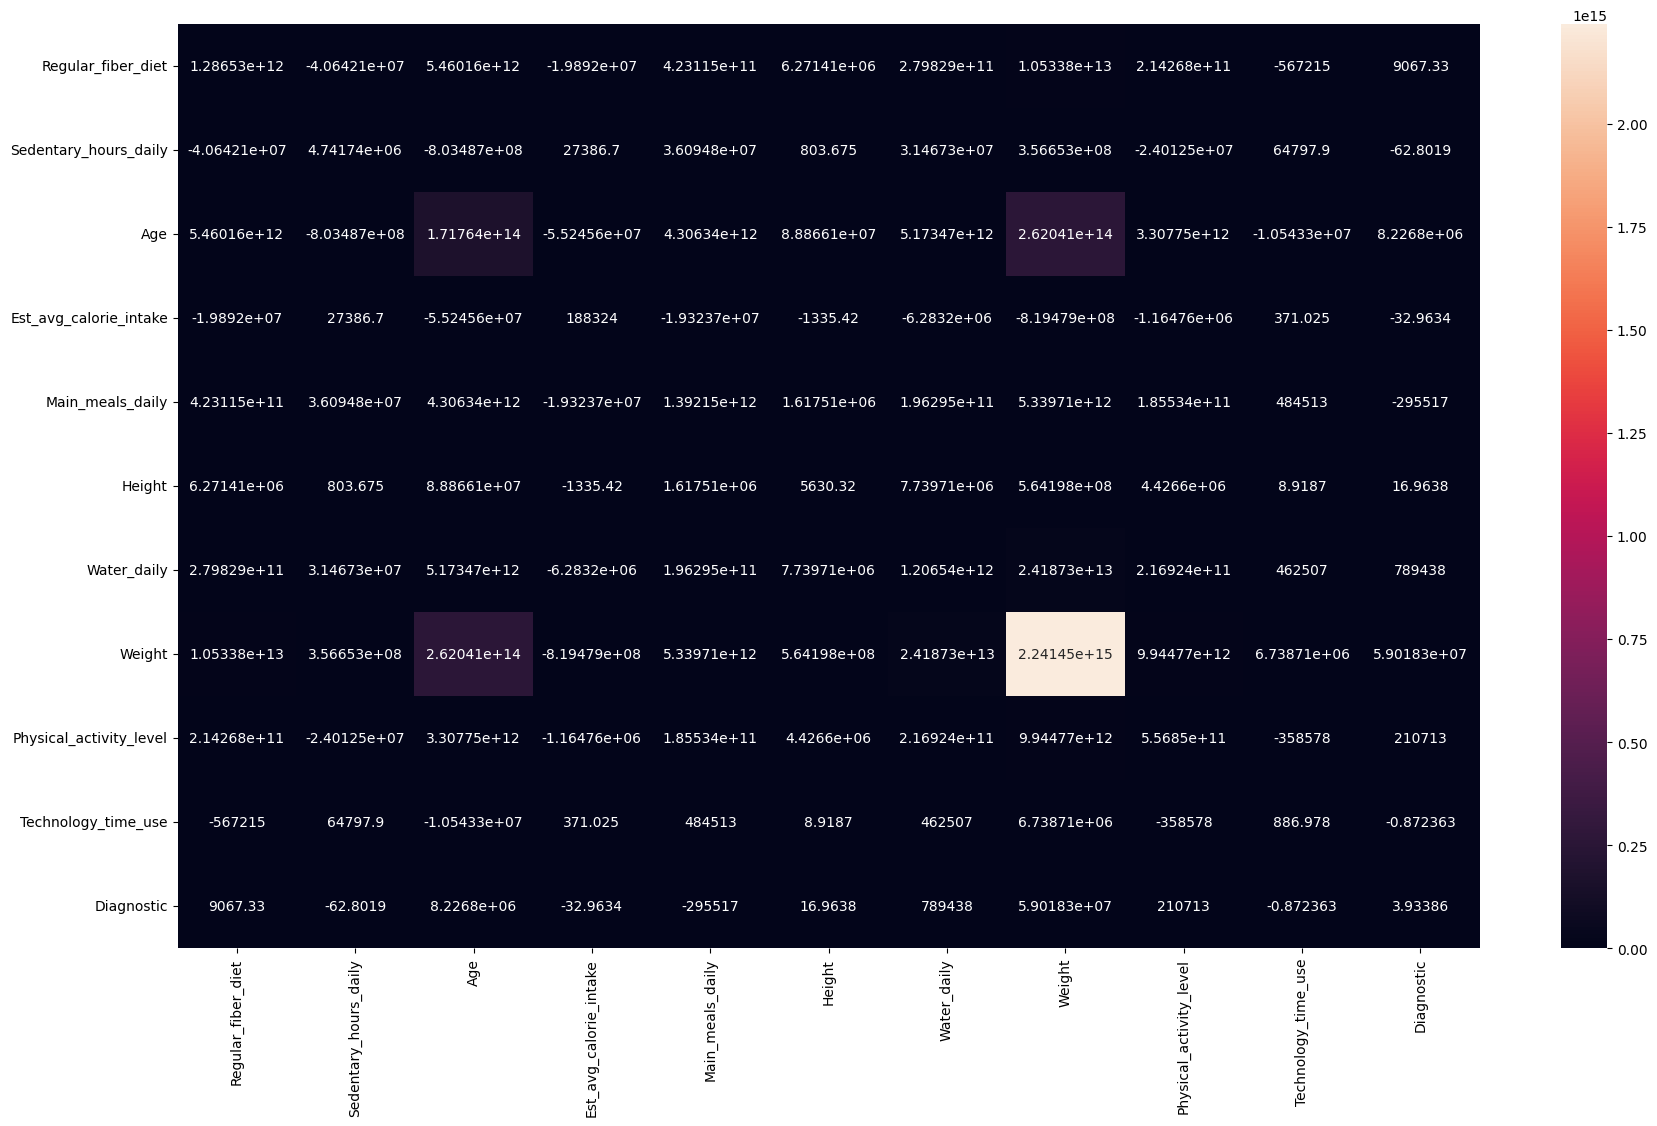

In [116]:
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

def plot_cov_matrix(dataset, lst):
    cov = np.cov(pd.DataFrame([dataset[elem] for elem in lst]), bias=True)
    labs = [elem for elem in lst]
    
    plt.figure(figsize = (21, 12))
    sns.heatmap(cov, annot=True, fmt='g', xticklabels=labs, yticklabels=labs)
    plt.show()

plot_cov_matrix(data, numerical_attributes + ["Diagnostic"])

## Data Preprocessing


Removed features:
['Main_meals_daily', 'Height', 'Water_daily', 'Calorie_monitoring']


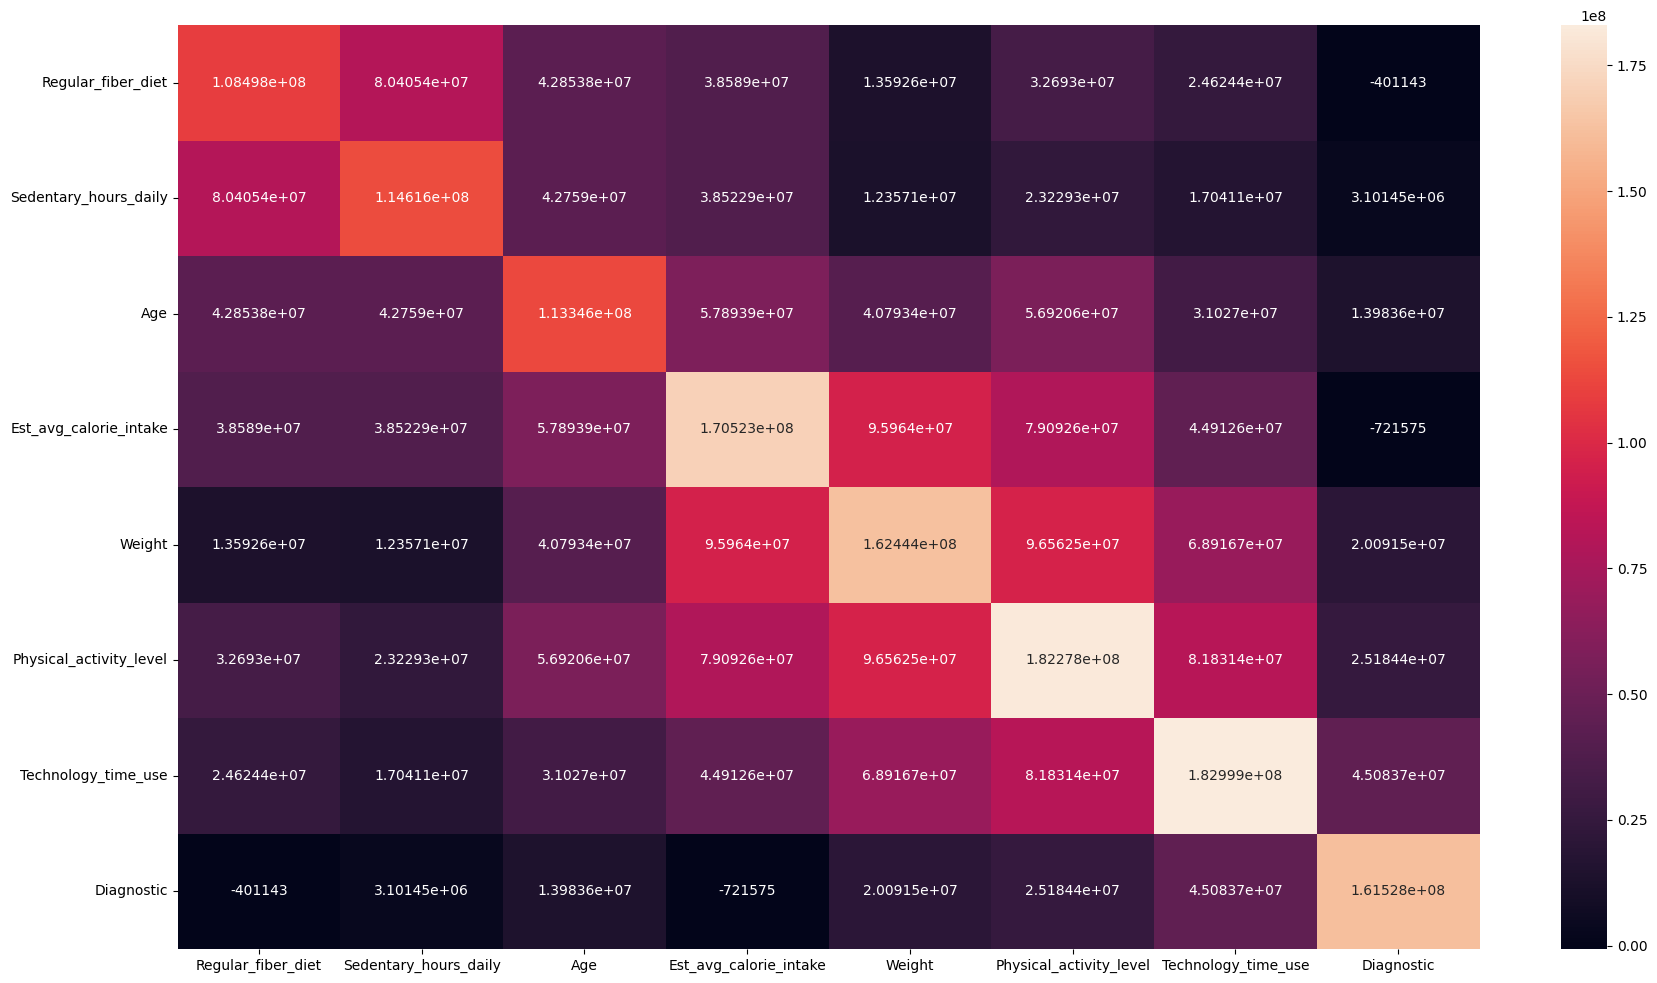

In [122]:

imp = IterativeImputer(missing_values= -1, sample_posterior=True, max_iter=int(1e10), random_state=0, tol=1e-10, imputation_order="random")

data["Weight"] = pd.DataFrame(imp.fit_transform(pd.DataFrame(data["Weight"])))

num_lines = data.shape[0]

scaler = RobustScaler(with_centering=False)

encoder = OneHotEncoder()

selector = SelectPercentile(score_func=mutual_info_classif, percentile=35)

X = data.loc[:, data.columns[:-1]]

y = data.loc[:, ["Diagnostic"]]

X = encoder.fit_transform(X, y)

X = scaler.fit_transform(X, y)

X  = selector.fit_transform(X, y)

mask_attr = selector.get_support(indices=False)

rem_features = [selected_feature[0] for selected_feature in zip(attributes, mask_attr) if selected_feature[1] == False]

attr_lst = diff(numerical_attributes + ["Diagnostic"], rem_features)

num_col = len(attr_lst)

print("\nRemoved features:\n" + str(rem_features))

for elem in range(num_div):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=elem * 10, train_size = .8)

    ml_dic_div[elem] = {}
    ml_dic_div[elem]["T"] = {}
    ml_dic_div[elem]["X"] = {}
    ml_dic_div[elem]["X"]["train"] = X_train
    ml_dic_div[elem]["T"]["train"] = y_train
    ml_dic_div[elem]["X"]["test"] = X_test
    ml_dic_div[elem]["T"]["test"] = y_test

plot_cov_matrix(pd.DataFrame(scaler.fit_transform([data[elem] for elem in attr_lst], y)
    .reshape(num_lines, num_col), columns=attr_lst), attr_lst)

In [118]:
def get_parameters(X, y, parameters, model):
    clf = GridSearchCV(model, parameters, n_jobs=-1)
    clf.fit(X, y)
    return clf.best_params_, clf.best_score_

In [119]:
def train_test_predict(num, model , parameters):

      X_train, T_train, X_test, T_test = ml_dic_div[num]["X"]["train"], ml_dic_div[num]["T"]["train"].values.ravel() \
                                                      , ml_dic_div[num]["X"]["test"], ml_dic_div[num]["T"]["test"].values.ravel()

      best_params, best_scores = get_parameters(X_train, T_train, parameters, model)

      print("Selected parameters:" + str(best_params))

      print("Best score " + str(best_scores))

      model.set_params(**best_params)

      print("\n")
      
      model.fit(X_train, T_train)
      y_test = model.predict(X_test)

      print("\n")
      print(classification_report(T_test, y_test))

      cm = confusion_matrix(T_test, y_test, labels=model.classes_)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
      disp.plot()
      plt.show()

      print("*"*50 + "\n")

## RandomForest using sklearn

Current split: 0 & Current scaler: RobustScaler()



Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.7, 'n_estimators': 300}
Best score 0.7102775075087778




              precision    recall  f1-score   support

           0       0.88      0.67      0.76        52
           1       0.68      0.88      0.76        57
           2       0.82      0.21      0.33        43
           3       0.83      0.45      0.59        55
           4       0.51      0.64      0.57        61
           5       0.58      0.91      0.71        54
           6       0.90      1.00      0.95        63

    accuracy                           0.70       385
   macro avg       0.74      0.68      0.67       385
weighted avg       0.74      0.70      0.68       385



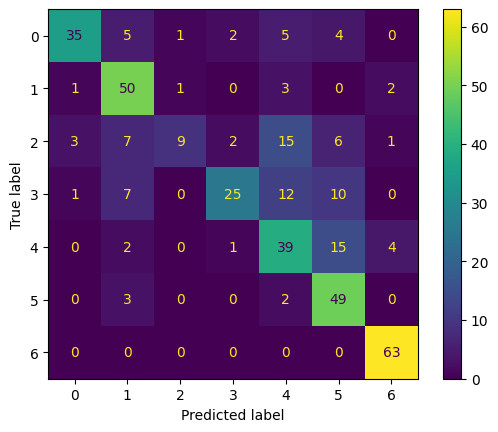

**************************************************

Current split: 1 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.8, 'n_estimators': 300}
Best score 0.708320994965946




              precision    recall  f1-score   support

           0       0.87      0.76      0.81        45
           1       0.68      0.79      0.73        66
           2       0.86      0.40      0.55        45
           3       0.81      0.31      0.45        55
           4       0.58      0.73      0.65        55
           5       0.57      0.96      0.72        50
           6       0.92      1.00      0.96        69

    accuracy                           0.72       385
   macro avg       0.76      0.71      0.69       385
weighted avg       0.76      0.72      0.70       385



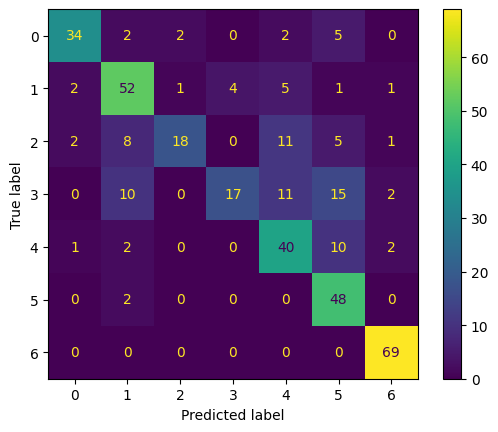

**************************************************

Current split: 2 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.8, 'n_estimators': 200}
Best score 0.7122636321333389




              precision    recall  f1-score   support

           0       0.89      0.60      0.72        53
           1       0.61      0.90      0.72        51
           2       0.94      0.29      0.44        52
           3       0.87      0.66      0.75        50
           4       0.69      0.76      0.72        70
           5       0.64      0.96      0.77        54
           6       0.89      0.98      0.93        55

    accuracy                           0.74       385
   macro avg       0.79      0.74      0.72       385
weighted avg       0.78      0.74      0.72       385



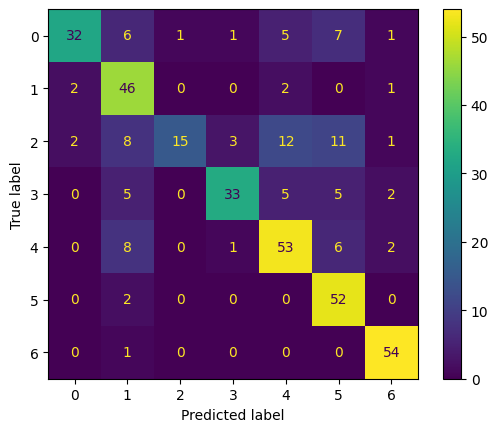

**************************************************

Current split: 3 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.8, 'n_estimators': 200}
Best score 0.7220165827657683




              precision    recall  f1-score   support

           0       0.92      0.63      0.75        54
           1       0.56      0.91      0.69        45
           2       0.94      0.31      0.46        49
           3       0.78      0.59      0.67        49
           4       0.74      0.74      0.74        70
           5       0.67      0.95      0.78        61
           6       0.86      0.98      0.92        57

    accuracy                           0.74       385
   macro avg       0.78      0.73      0.72       385
weighted avg       0.78      0.74      0.73       385



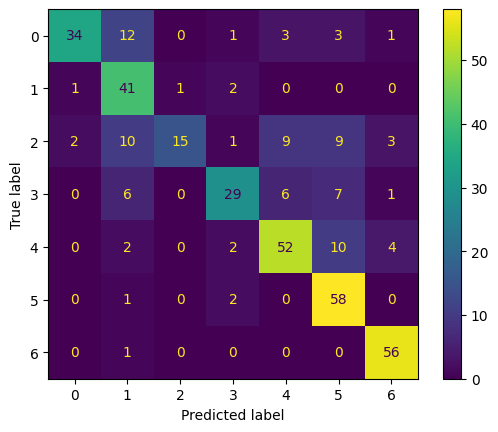

**************************************************

Current split: 4 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.7, 'n_estimators': 300}
Best score 0.7148652650281314




              precision    recall  f1-score   support

           0       1.00      0.72      0.84        50
           1       0.68      0.84      0.75        49
           2       0.94      0.32      0.48        47
           3       0.71      0.67      0.69        48
           4       0.72      0.70      0.71        84
           5       0.61      0.92      0.73        59
           6       0.84      1.00      0.91        48

    accuracy                           0.74       385
   macro avg       0.79      0.74      0.73       385
weighted avg       0.77      0.74      0.73       385



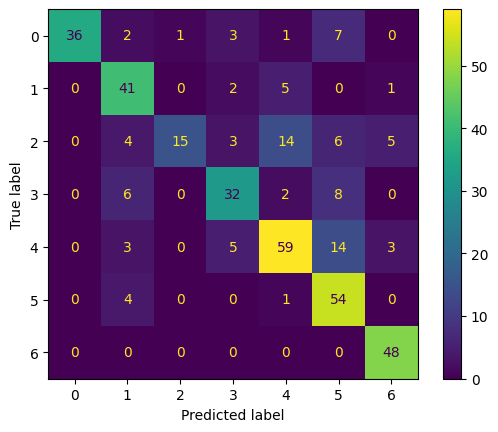

**************************************************



In [18]:
target = "Diagnostic"
parameters = {"n_estimators":[elem for elem in range(100, 400, 100)], \
        "max_depth":[elem for elem in range(7, 15)], "criterion":["gini", "entropy"], "max_samples":[0.6, 0.7, 0.8]}
random_forest_model = RandomForestClassifier(n_jobs=-1)

for test_num in range(num_div):
        print("Current split: {} & Current scaler: {}\n".format(test_num, RobustScaler()))
        train_test_predict(test_num, random_forest_model, parameters)

## ExtraTrees using sklearn

Current split: 0 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.7, 'n_estimators': 200}
Best score 0.7167815897457591




              precision    recall  f1-score   support

           0       0.86      0.73      0.79        52
           1       0.68      0.81      0.74        57
           2       0.90      0.21      0.34        43
           3       0.72      0.38      0.50        55
           4       0.47      0.62      0.54        61
           5       0.61      0.93      0.74        54
           6       0.89      1.00      0.94        63

    accuracy                           0.69       385
   macro avg       0.73      0.67      0.65       385
weighted avg       0.73      0.69      0.67       385



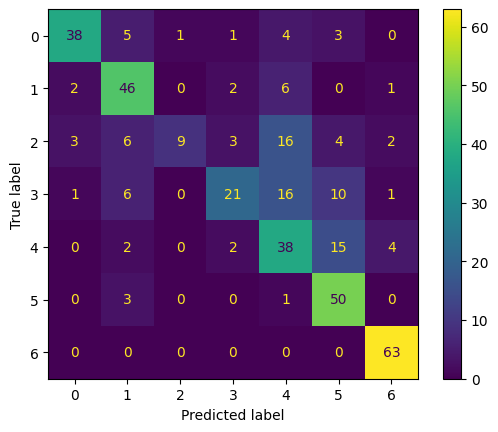

**************************************************

Current split: 1 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.7, 'n_estimators': 200}
Best score 0.7089682304666017




              precision    recall  f1-score   support

           0       0.88      0.80      0.84        45
           1       0.72      0.79      0.75        66
           2       0.89      0.36      0.51        45
           3       0.81      0.31      0.45        55
           4       0.51      0.73      0.60        55
           5       0.60      0.94      0.73        50
           6       0.90      1.00      0.95        69

    accuracy                           0.72       385
   macro avg       0.76      0.70      0.69       385
weighted avg       0.76      0.72      0.70       385



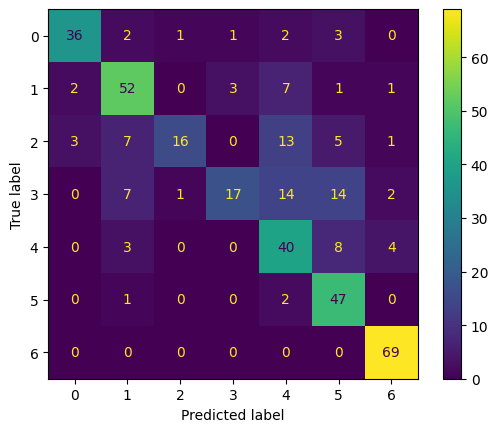

**************************************************

Current split: 2 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'log_loss', 'max_depth': 14, 'max_samples': 0.6, 'n_estimators': 300}
Best score 0.705108084098312




              precision    recall  f1-score   support

           0       0.83      0.64      0.72        53
           1       0.62      0.88      0.73        51
           2       0.88      0.27      0.41        52
           3       0.79      0.62      0.70        50
           4       0.68      0.73      0.70        70
           5       0.63      0.94      0.76        54
           6       0.90      0.98      0.94        55

    accuracy                           0.73       385
   macro avg       0.76      0.72      0.71       385
weighted avg       0.76      0.73      0.71       385



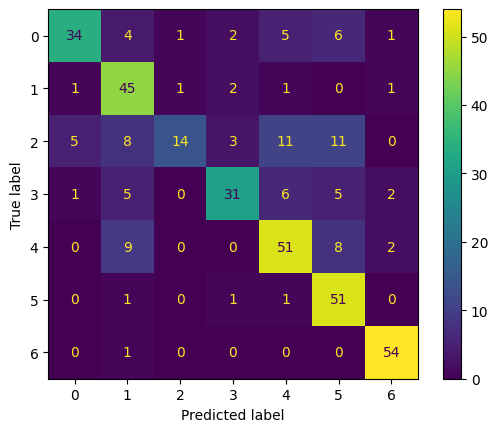

**************************************************

Current split: 3 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'log_loss', 'max_depth': 14, 'max_samples': 0.7, 'n_estimators': 300}
Best score 0.719408604424891




              precision    recall  f1-score   support

           0       0.94      0.63      0.76        54
           1       0.57      0.87      0.69        45
           2       0.89      0.33      0.48        49
           3       0.70      0.57      0.63        49
           4       0.73      0.70      0.72        70
           5       0.63      0.95      0.76        61
           6       0.88      0.98      0.93        57

    accuracy                           0.73       385
   macro avg       0.76      0.72      0.71       385
weighted avg       0.76      0.73      0.71       385



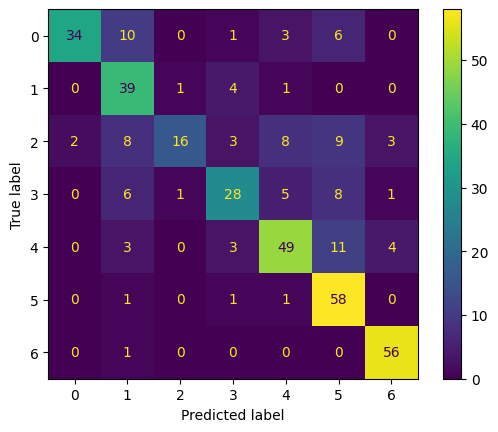

**************************************************

Current split: 4 & Current scaler: RobustScaler()

Selected parameters:{'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.8, 'n_estimators': 300}
Best score 0.7129024070392147




              precision    recall  f1-score   support

           0       0.97      0.68      0.80        50
           1       0.63      0.82      0.71        49
           2       0.94      0.34      0.50        47
           3       0.77      0.69      0.73        48
           4       0.75      0.76      0.76        84
           5       0.61      0.90      0.73        59
           6       0.87      1.00      0.93        48

    accuracy                           0.75       385
   macro avg       0.79      0.74      0.74       385
weighted avg       0.78      0.75      0.74       385



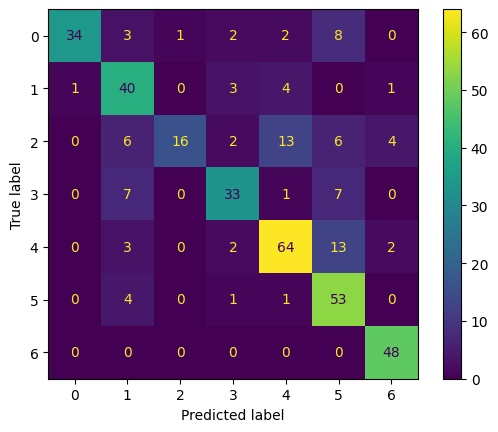

**************************************************



In [19]:
target = "Diagnostic"
parameters = {"n_estimators":[elem for elem in range(100, 400, 100)], \
        "max_depth":[elem for elem in range(7, 15)], "criterion":["gini", "entropy", "log_loss"], "max_samples":[0.6, 0.7, 0.8]}
extra_trees_model = ExtraTreesClassifier(n_jobs=-1, bootstrap=True)

for test_num in range(num_div):
        print("Current split: {} & Current scaler: {}\n".format(test_num, RobustScaler()))
        train_test_predict(test_num, extra_trees_model, parameters)

## Support Vector Machines using sklearn

Current split: 0 & Current scaler: RobustScaler()



Selected parameters:{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8261686196539617




              precision    recall  f1-score   support

           0       0.91      0.83      0.87        52
           1       0.67      0.81      0.73        57
           2       0.86      0.70      0.77        43
           3       0.73      0.67      0.70        55
           4       0.75      0.80      0.78        61
           5       0.80      0.81      0.81        54
           6       1.00      1.00      1.00        63

    accuracy                           0.81       385
   macro avg       0.82      0.80      0.81       385
weighted avg       0.82      0.81      0.81       385



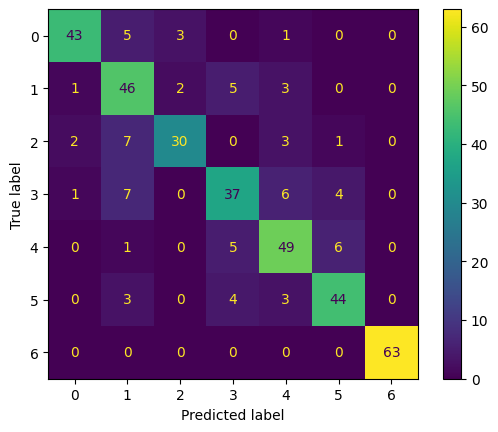

**************************************************

Current split: 1 & Current scaler: RobustScaler()

Selected parameters:{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8189961504293752




              precision    recall  f1-score   support

           0       0.90      0.82      0.86        45
           1       0.71      0.79      0.75        66
           2       0.73      0.78      0.75        45
           3       0.78      0.53      0.63        55
           4       0.77      0.84      0.80        55
           5       0.81      0.92      0.86        50
           6       1.00      1.00      1.00        69

    accuracy                           0.82       385
   macro avg       0.81      0.81      0.81       385
weighted avg       0.82      0.82      0.81       385



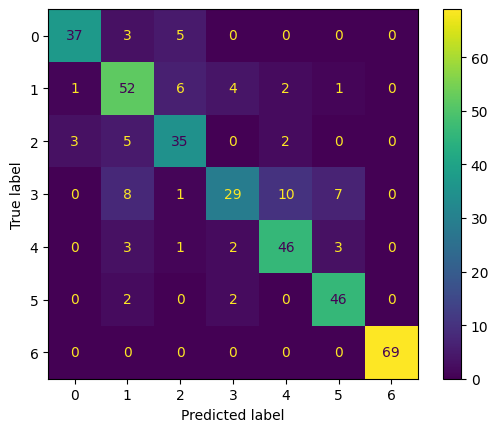

**************************************************

Current split: 2 & Current scaler: RobustScaler()

Selected parameters:{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8190384534032743




              precision    recall  f1-score   support

           0       0.93      0.77      0.85        53
           1       0.64      0.92      0.75        51
           2       0.81      0.75      0.78        52
           3       0.75      0.72      0.73        50
           4       0.81      0.71      0.76        70
           5       0.93      0.94      0.94        54
           6       1.00      0.98      0.99        55

    accuracy                           0.83       385
   macro avg       0.84      0.83      0.83       385
weighted avg       0.84      0.83      0.83       385



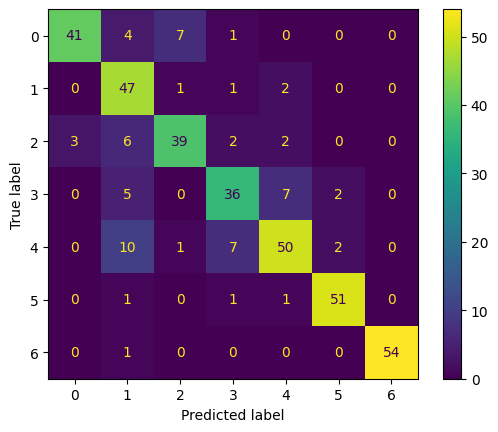

**************************************************

Current split: 3 & Current scaler: RobustScaler()

Selected parameters:{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8229070603663438




              precision    recall  f1-score   support

           0       0.93      0.76      0.84        54
           1       0.61      0.91      0.73        45
           2       0.83      0.71      0.77        49
           3       0.74      0.76      0.75        49
           4       0.90      0.79      0.84        70
           5       0.88      0.93      0.90        61
           6       1.00      0.98      0.99        57

    accuracy                           0.84       385
   macro avg       0.84      0.83      0.83       385
weighted avg       0.85      0.84      0.84       385



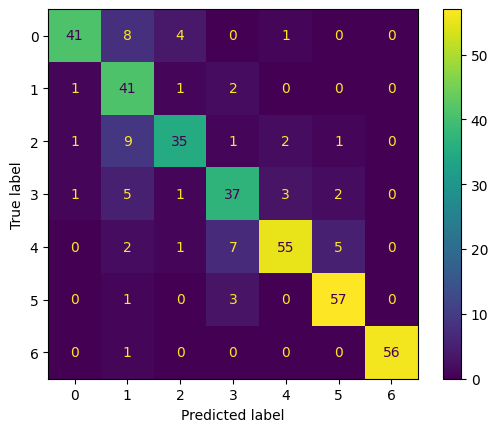

**************************************************

Current split: 4 & Current scaler: RobustScaler()

Selected parameters:{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8125301408689032




              precision    recall  f1-score   support

           0       0.98      0.82      0.89        50
           1       0.68      0.88      0.77        49
           2       0.85      0.83      0.84        47
           3       0.73      0.83      0.78        48
           4       0.89      0.77      0.83        84
           5       0.86      0.85      0.85        59
           6       1.00      1.00      1.00        48

    accuracy                           0.85       385
   macro avg       0.86      0.85      0.85       385
weighted avg       0.86      0.85      0.85       385



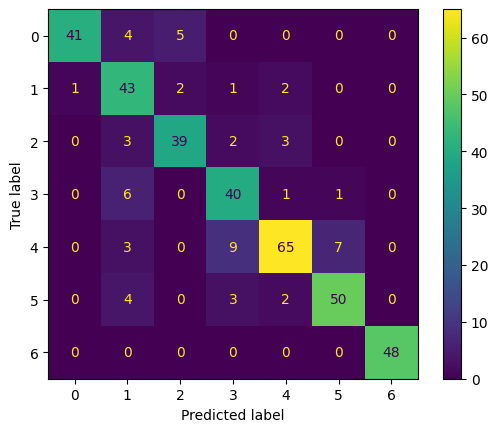

**************************************************



In [123]:
target = "Diagnostic"
parameters = {"kernel":["linear", "rbf", "poly", "sigmoid"], \
            "C":[elem for elem in range(1, 100)], "gamma":["scale", "auto"]}
svm_model = svm.SVC()

for test_num in range(num_div):
    print("Current split: {} & Current scaler: {}\n".format(test_num, RobustScaler()))
    train_test_predict(test_num, svm_model, parameters)

## GradientBoosted Tree using xgboost

Current split: 0 & Current scaler: RobustScaler()

Selected parameters:{'learning_rate': 1e-07, 'max_depth': 14, 'n_estimators': 200}
Best score 0.7057193620711535




              precision    recall  f1-score   support

           0       0.74      0.67      0.71        52
           1       0.64      0.65      0.64        57
           2       0.72      0.42      0.53        43
           3       0.74      0.62      0.67        55
           4       0.65      0.75      0.70        61
           5       0.67      0.89      0.76        54
           6       0.95      1.00      0.98        63

    accuracy                           0.73       385
   macro avg       0.73      0.71      0.71       385
weighted avg       0.73      0.73      0.72       385



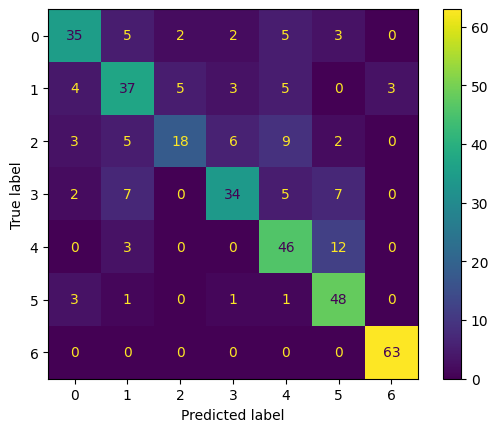

**************************************************

Current split: 1 & Current scaler: RobustScaler()

Selected parameters:{'learning_rate': 1e-07, 'max_depth': 11, 'n_estimators': 300}
Best score 0.7096091205211725




              precision    recall  f1-score   support

           0       0.78      0.78      0.78        45
           1       0.66      0.62      0.64        66
           2       0.71      0.44      0.55        45
           3       0.68      0.42      0.52        55
           4       0.65      0.82      0.73        55
           5       0.67      0.98      0.80        50
           6       0.93      1.00      0.97        69

    accuracy                           0.73       385
   macro avg       0.73      0.72      0.71       385
weighted avg       0.73      0.73      0.72       385



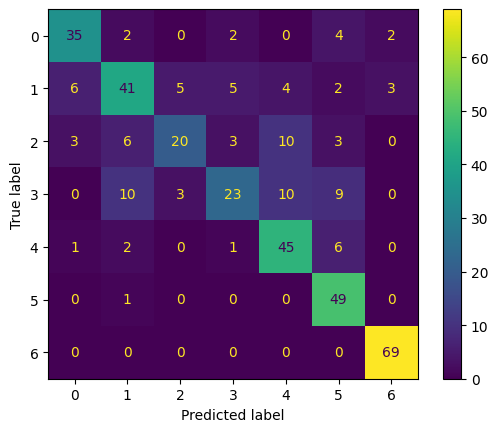

**************************************************

Current split: 2 & Current scaler: RobustScaler()

Selected parameters:{'learning_rate': 1e-05, 'max_depth': 13, 'n_estimators': 100}
Best score 0.6985976564152458




              precision    recall  f1-score   support

           0       0.74      0.70      0.72        53
           1       0.58      0.76      0.66        51
           2       0.78      0.35      0.48        52
           3       0.80      0.64      0.71        50
           4       0.69      0.76      0.72        70
           5       0.71      0.96      0.82        54
           6       0.98      0.98      0.98        55

    accuracy                           0.74       385
   macro avg       0.76      0.74      0.73       385
weighted avg       0.75      0.74      0.73       385



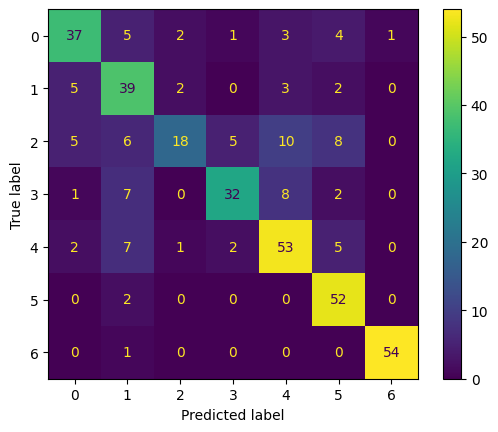

**************************************************

Current split: 3 & Current scaler: RobustScaler()

Selected parameters:{'learning_rate': 1e-07, 'max_depth': 14, 'n_estimators': 100}
Best score 0.7057235923685434




              precision    recall  f1-score   support

           0       0.87      0.61      0.72        54
           1       0.55      0.78      0.64        45
           2       0.70      0.33      0.44        49
           3       0.67      0.61      0.64        49
           4       0.74      0.80      0.77        70
           5       0.71      0.95      0.81        61
           6       0.98      0.98      0.98        57

    accuracy                           0.74       385
   macro avg       0.74      0.72      0.71       385
weighted avg       0.75      0.74      0.73       385



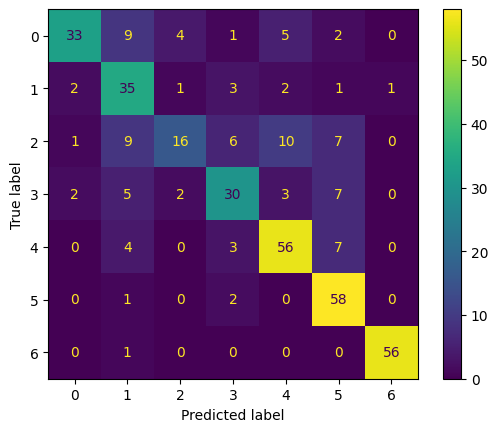

**************************************************

Current split: 4 & Current scaler: RobustScaler()

Selected parameters:{'learning_rate': 1e-07, 'max_depth': 14, 'n_estimators': 300}
Best score 0.6946804010321925




              precision    recall  f1-score   support

           0       0.87      0.68      0.76        50
           1       0.60      0.69      0.64        49
           2       0.73      0.40      0.52        47
           3       0.60      0.67      0.63        48
           4       0.74      0.71      0.73        84
           5       0.66      0.88      0.75        59
           6       0.96      1.00      0.98        48

    accuracy                           0.72       385
   macro avg       0.74      0.72      0.72       385
weighted avg       0.74      0.72      0.72       385



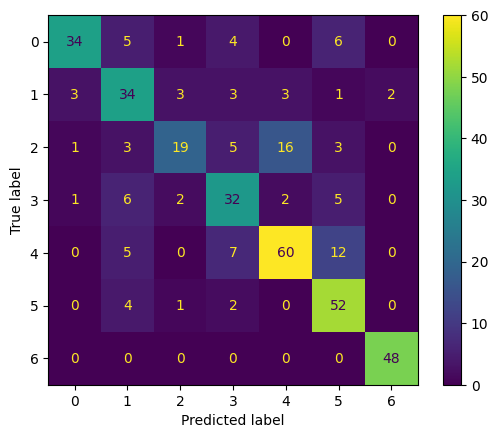

**************************************************



In [70]:
target = "Diagnostic"
parameters = {"n_estimators":[elem for elem in range(100, 400, 100)], \
        "max_depth":[elem for elem in range(7, 15)], "learning_rate":[1e-5, 1e-6, 1e-7]}
grad_boosted_model = xgb.XGBClassifier(tree_method="hist", subsample = 0.5, max_cat_to_onehot=1)

for test_num in range(num_div):
        print("Current split: {} & Current scaler: {}\n".format(test_num, RobustScaler()))
        train_test_predict(test_num, grad_boosted_model, parameters)